now working /home/ken/src/github.com/endaaman/bt



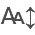

In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
from sklearn.decomposition import PCA
import ipynbname
from endaaman.ml import fix_global_seed
from itables import init_notebook_mode
# from ydata_profiling import ProfileReport

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 300

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

init_notebook_mode(all_interactive=True)
# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

LIMIT = 500

## Table2: Cross Validation

In [2]:
mm = [
    'Accuracy(Patch)', 
    'Accuracy', 
    'Recall', 
    # 'Precision', 
    # 'F1 score', 
    'G Recall', 
    'A Recall', 
    'O Recall', 
    'M Recall', 
    'L Recall', 
]

skip_when_coarse = ['A Recall', 'O Recall']

def dump_to_table(target, coarse=False, result_limit=100):
    r = None
    error_type = 'ci'
    grains = 'coarse' if coarse else 'fine'
    P = f'out/figs/table2_{grains}_{target}.xlsx'
    with pd.ExcelWriter(P) as w:
        for limit in [10, 25, 100, 500]:
            df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)
            data = []
            labels = df['label'].unique()
            for l in labels:
                vvv = df[df['label'] == l]
                ss = {}
                for m in mm:
                    if coarse and m in skip_when_coarse:
                        continue
                    vv = vvv[m].values
                    mean = np.mean(vv)
                    if len(vv) > 0 and vv.std() > 0:
                        if error_type == 'ci':
                            ci = stats.t.interval(confidence=0.95, df=len(vv)-1, loc=mean, scale=stats.sem(vv))
                            error = (ci[1] - ci[0])/2
                        else:
                            error = stats.sem(vv)
                    else:
                        error = 0.0
                    s = '{:.3f} ± {:.3f}'.format(mean, error)
                    ss[m] = s
                data.append(ss)
            df2 = pd.DataFrame(data, index=labels)
            df2.to_excel(w, sheet_name=f'{limit}')
            w.sheets[f'{limit}'].set_column('A:A', 30)
            w.sheets[f'{limit}'].set_column('B:Z', 12)
            if limit == result_limit:
                r = df2
    print(f'wrote {P}')
    return r 

## Table2: Local cross-validation

In [3]:
dump_to_table('cv', False, LIMIT)

wrote out/figs/table2_fine_cv.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.931 ± 0.024  0.949 ± 0.040   
UNI(FT)                            0.936 ± 0.015  0.942 ± 0.033   
UNI(LP)                            0.929 ± 0.026  0.949 ± 0.042   
CTransPath(FT)                     0.921 ± 0.022  0.947 ± 0.042   
CTransPath(LP)                     0.901 ± 0.026  0.939 ± 0.017   
VIT-L$\mathrm{_{IN}}$(FT)          0.913 ± 0.023  0.927 ± 0.028   
VIT-L$\mathrm{_{IN}}$(LP)          0.861 ± 0.031  0.907 ± 0.024   
VIT-L(RI)                          0.858 ± 0.019  0.901 ± 0.029   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.914 ± 0.016  0.937 ± 0.037   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.377 ± 0.090  0.369 ± 0.119   

                                         Recall       G Recall       A Recall  \
Prov-GigaPath(LP)                 0.881 ± 0.100  0.954 ± 0.052  0.527 ± 0.459   
UNI(FT)                           0.866 ± 0.072  0.985 ± 0.043  0.387 ± 0.353   
UNI(LP)                           0.883 ± 0.093  0.969 ± 0.052  0.493 ± 0.425   
CTransPath(FT)                    0.879 ± 0.091  0.969 ± 0.052  0.460 ± 0.408   
CTransPath(LP)                    0.870 ± 0.065  0.938 ± 0.125  0.467 ± 0.384   
VIT-L$\mathrm{_{IN}}$(FT)         0.833 ± 0.084  0.954 ± 0.085  0.340 ± 0.299   
VIT-L$\mathrm{_{IN}}$(LP)         0.829 ± 0.045  0.847 ± 0.192  0.387 ± 0.251   
VIT-L(RI)                         0.827 ± 0.042  0.924 ± 0.068  0.580 ± 0.309   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.853 ± 0.101  0.985 ± 0.043  0.347 ± 0.508   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.355 ± 0.069  0.000 ± 0.000  0.000 ± 0.000   

                                       O Recall       M Recall       L Recall  
Prov-GigaPath(LP)                 0.820 ± 0.254  0.988 ± 0.035  1.000 ± 0.000  
UNI(FT)                           0.870 ± 0.150  0.976 ± 0.041  0.980 ± 0.056  
UNI(LP)                           0.870 ± 0.150  0.988 ± 0.035  0.980 ± 0.056  
CTransPath(FT)                    0.870 ± 0.150  0.976 ± 0.041  1.000 ± 0.000  
CTransPath(LP)                    0.870 ± 0.150  0.988 ± 0.035  0.960 ± 0.068  
VIT-L$\mathrm{_{IN}}$(FT)         0.750 ± 0.271  0.975 ± 0.069  0.980 ± 0.056  
VIT-L$\mathrm{_{IN}}$(LP)         0.870 ± 0.150  0.951 ± 0.065  0.922 ± 0.103  
VIT-L(RI)                         0.710 ± 0.374  0.902 ± 0.084  0.844 ± 0.109  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.830 ± 0.121  0.975 ± 0.043  0.980 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.920 ± 0.136  0.000 ± 0.000  0.569 ± 0.356

In [4]:
dump_to_table('ebrains', False, LIMIT)

wrote out/figs/table2_fine_ebrains.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.624 ± 0.060  0.659 ± 0.067   
UNI(FT)                            0.588 ± 0.021  0.621 ± 0.028   
UNI(LP)                            0.613 ± 0.009  0.650 ± 0.011   
CTransPath(FT)                     0.546 ± 0.023  0.584 ± 0.021   
CTransPath(LP)                     0.549 ± 0.019  0.600 ± 0.022   
VIT-L$\mathrm{_{IN}}$(FT)          0.503 ± 0.032  0.539 ± 0.032   
VIT-L$\mathrm{_{IN}}$(LP)          0.469 ± 0.036  0.532 ± 0.040   
VIT-L(RI)                          0.411 ± 0.052  0.458 ± 0.062   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.485 ± 0.033  0.520 ± 0.034   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.164 ± 0.045  0.318 ± 0.021   

                                         Recall       G Recall       A Recall  \
Prov-GigaPath(LP)                 0.729 ± 0.038  0.713 ± 0.111  0.623 ± 0.048   
UNI(FT)                           0.698 ± 0.021  0.718 ± 0.046  0.330 ± 0.106   
UNI(LP)                           0.734 ± 0.009  0.669 ± 0.069  0.595 ± 0.059   
CTransPath(FT)                    0.671 ± 0.009  0.687 ± 0.063  0.440 ± 0.055   
CTransPath(LP)                    0.683 ± 0.016  0.637 ± 0.047  0.580 ± 0.081   
VIT-L$\mathrm{_{IN}}$(FT)         0.626 ± 0.024  0.710 ± 0.097  0.268 ± 0.113   
VIT-L$\mathrm{_{IN}}$(LP)         0.624 ± 0.029  0.631 ± 0.112  0.396 ± 0.207   
VIT-L(RI)                         0.538 ± 0.042  0.555 ± 0.115  0.278 ± 0.096   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.612 ± 0.025  0.658 ± 0.088  0.258 ± 0.086   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.283 ± 0.039  0.000 ± 0.000  0.098 ± 0.150   

                                       O Recall       M Recall       L Recall  
Prov-GigaPath(LP)                 0.464 ± 0.090  0.898 ± 0.022  0.949 ± 0.000  
UNI(FT)                           0.592 ± 0.126  0.889 ± 0.012  0.963 ± 0.009  
UNI(LP)                           0.497 ± 0.058  0.953 ± 0.022  0.956 ± 0.019  
CTransPath(FT)                    0.415 ± 0.052  0.877 ± 0.043  0.939 ± 0.019  
CTransPath(LP)                    0.400 ± 0.086  0.885 ± 0.014  0.912 ± 0.040  
VIT-L$\mathrm{_{IN}}$(FT)         0.408 ± 0.092  0.851 ± 0.046  0.895 ± 0.040  
VIT-L$\mathrm{_{IN}}$(LP)         0.351 ± 0.256  0.868 ± 0.060  0.871 ± 0.035  
VIT-L(RI)                         0.314 ± 0.116  0.749 ± 0.051  0.793 ± 0.089  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.398 ± 0.057  0.847 ± 0.034  0.902 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.834 ± 0.126  0.000 ± 0.000  0.485 ± 0.203

## Table2: EBRAINS

In [5]:
dump_to_table('cv', True, LIMIT)

wrote out/figs/table2_coarse_cv.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.972 ± 0.014  0.992 ± 0.014   
UNI(FT)                            0.974 ± 0.012  0.990 ± 0.013   
UNI(LP)                            0.972 ± 0.015  0.990 ± 0.013   
CTransPath(FT)                     0.962 ± 0.014  0.990 ± 0.017   
CTransPath(LP)                     0.948 ± 0.013  0.985 ± 0.013   
VIT-L$\mathrm{_{IN}}$(FT)          0.954 ± 0.017  0.985 ± 0.013   
VIT-L$\mathrm{_{IN}}$(LP)          0.909 ± 0.018  0.952 ± 0.021   
VIT-L(RI)                          0.911 ± 0.017  0.947 ± 0.026   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.956 ± 0.011  0.990 ± 0.007   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.516 ± 0.060  0.543 ± 0.084   

                                         Recall       G Recall       M Recall  \
Prov-GigaPath(LP)                 0.992 ± 0.014  0.982 ± 0.030  0.988 ± 0.035   
UNI(FT)                           0.987 ± 0.016  0.991 ± 0.024  0.976 ± 0.041   
UNI(LP)                           0.987 ± 0.016  0.982 ± 0.030  0.988 ± 0.035   
CTransPath(FT)                    0.989 ± 0.018  0.982 ± 0.030  0.976 ± 0.041   
CTransPath(LP)                    0.980 ± 0.017  0.974 ± 0.047  0.988 ± 0.035   
VIT-L$\mathrm{_{IN}}$(FT)         0.982 ± 0.015  0.974 ± 0.049  0.975 ± 0.069   
VIT-L$\mathrm{_{IN}}$(LP)         0.944 ± 0.022  0.905 ± 0.097  0.951 ± 0.065   
VIT-L(RI)                         0.926 ± 0.039  0.957 ± 0.002  0.902 ± 0.084   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.987 ± 0.011  0.991 ± 0.024  0.975 ± 0.043   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.499 ± 0.087  0.784 ± 0.188  0.000 ± 0.000   

                                       L Recall  
Prov-GigaPath(LP)                 1.000 ± 0.000  
UNI(FT)                           0.980 ± 0.056  
UNI(LP)                           0.980 ± 0.056  
CTransPath(FT)                    1.000 ± 0.000  
CTransPath(LP)                    0.960 ± 0.068  
VIT-L$\mathrm{_{IN}}$(FT)         0.980 ± 0.056  
VIT-L$\mathrm{_{IN}}$(LP)         0.922 ± 0.103  
VIT-L(RI)                         0.844 ± 0.109  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.980 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.569 ± 0.356

In [6]:
dump_to_table('ebrains', True, LIMIT)

wrote out/figs/table2_coarse_ebrains.xlsx


Accuracy(Patch)       Accuracy  \
Prov-GigaPath(LP)                  0.883 ± 0.015  0.915 ± 0.016   
UNI(FT)                            0.865 ± 0.044  0.889 ± 0.047   
UNI(LP)                            0.901 ± 0.013  0.928 ± 0.019   
CTransPath(FT)                     0.857 ± 0.029  0.898 ± 0.016   
CTransPath(LP)                     0.854 ± 0.023  0.914 ± 0.019   
VIT-L$\mathrm{_{IN}}$(FT)          0.804 ± 0.050  0.856 ± 0.041   
VIT-L$\mathrm{_{IN}}$(LP)          0.726 ± 0.045  0.787 ± 0.035   
VIT-L(RI)                          0.703 ± 0.059  0.768 ± 0.068   
ResNet-RS 50$\mathrm{_{IN}}$(FT)   0.791 ± 0.034  0.839 ± 0.034   
ResNet-RS 50$\mathrm{_{IN}}$(LP)   0.470 ± 0.152  0.746 ± 0.053   

                                         Recall       G Recall       M Recall  \
Prov-GigaPath(LP)                 0.920 ± 0.007  0.913 ± 0.021  0.898 ± 0.022   
UNI(FT)                           0.911 ± 0.022  0.880 ± 0.055  0.889 ± 0.012   
UNI(LP)                           0.944 ± 0.008  0.922 ± 0.024  0.953 ± 0.022   
CTransPath(FT)                    0.904 ± 0.011  0.895 ± 0.023  0.877 ± 0.043   
CTransPath(LP)                    0.904 ± 0.011  0.916 ± 0.025  0.885 ± 0.014   
VIT-L$\mathrm{_{IN}}$(FT)         0.866 ± 0.019  0.852 ± 0.054  0.851 ± 0.046   
VIT-L$\mathrm{_{IN}}$(LP)         0.836 ± 0.020  0.769 ± 0.046  0.868 ± 0.060   
VIT-L(RI)                         0.769 ± 0.032  0.765 ± 0.087  0.749 ± 0.051   
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.860 ± 0.012  0.831 ± 0.043  0.847 ± 0.034   
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.444 ± 0.044  0.849 ± 0.085  0.000 ± 0.000   

                                       L Recall  
Prov-GigaPath(LP)                 0.949 ± 0.000  
UNI(FT)                           0.963 ± 0.009  
UNI(LP)                           0.956 ± 0.019  
CTransPath(FT)                    0.939 ± 0.019  
CTransPath(LP)                    0.912 ± 0.040  
VIT-L$\mathrm{_{IN}}$(FT)         0.895 ± 0.040  
VIT-L$\mathrm{_{IN}}$(LP)         0.871 ± 0.035  
VIT-L(RI)                         0.793 ± 0.089  
ResNet-RS 50$\mathrm{_{IN}}$(FT)  0.902 ± 0.056  
ResNet-RS 50$\mathrm{_{IN}}$(LP)  0.485 ± 0.203

## fig3: Box - Cross Validation

In [7]:
import random
import colorcet as cc

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'VIT-L$\mathrm{_{IN}}$(FT)',
    r'VIT-L$\mathrm{_{IN}}$(LP)',
    r'VIT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50(RI)',
]
print(len(labels))
# colors = sns.color_palette('pastel20', len(label))
colors = sns.color_palette(cc.glasbey_hv, n_colors=len(labels))
color_map = dict(zip(labels, colors))
display(colors)

11


[(0.18824, 0.63529, 0.85490),
 (0.98823, 0.30980, 0.18824),
 (0.89804, 0.68235, 0.21961),
 (0.42745, 0.56471, 0.30980),
 (0.54510, 0.54510, 0.54510),
 (0.09020, 0.74510, 0.81176),
 (0.58039, 0.40392, 0.74118),
 (0.83922, 0.15294, 0.15686),
 (0.12157, 0.46667, 0.70588),
 (0.89020, 0.46667, 0.76078),
 (0.54902, 0.33726, 0.29412)]

In [35]:
from statsmodels.stats.multitest import multipletests

verbose = False

def paired_box(target:str, 
               coarse:bool, 
               limit:int, 
               key:str, 
               show:bool=False, 
               excludes=['frozen_baseline-cnn'],
               sort=False,
               mean=False,
               log_scale=False,
              ):
    grains = 'coarse' if coarse else 'fine'
    key_map = {
        'pacc': 'Accuracy(Patch)',
        'recall': 'Recall',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }
    key_label = key_map[key]
    
    df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)    
    for e in excludes:
        df = df[~df['cond'].str.startswith(e)]
    labels = list(df['label'].unique())

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df[f'average_{key}'] = df['cond'].map(df_mean)
    if sort:
        df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
    else:
        df = df[::-1]    
    labels_sorted = df['label'].unique()

    # Create figure with GridSpec
    fig = plt.figure(figsize=(8, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[20, 1], height_ratios=[3, 1], hspace=0.5, wspace=0.2)

    # Create axes
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = fig.add_subplot(gs[1, 1])

    # Box plot
    
    sns.boxplot(x='label', hue='label', y=key_label, data=df, legend=True, palette=[color_map[label] for label in labels_sorted], ax=ax1)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax1.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.3, linewidth=0.5)
    
    # Scatter individual points
    for i, label in enumerate(labels_sorted):
        ax1.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    # Plot mean
    if mean:
        ax1.plot(range(n_models), df_mean, 'firebrick', linewidth=1, zorder=4, alpha=0.4)

    mean_scatter = ax1.scatter(
        labels, 
        [df[df['label'] == l][key_label].mean() for l in labels],
        color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    ax1.set_title(key_label)
    ax1.set_xticks(range(len(labels_sorted)))
    ax1.set_xticklabels(labels_sorted, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.set_ylabel(key_label)


    # Calculate p-values
    p_values = []
    for i in range(n_models):
        for j in range(i+1, n_models):
            a = df[df['label']==labels_sorted[i]][key_label]
            b = df[df['label']==labels_sorted[j]][key_label]
            t_stat, p_value = stats.ttest_rel(a, b)
            p_values.append(p_value)

    # Benjamini-Hochberg correction
    _, p_values, _, _ = multipletests(p_values, method='fdr_bh')


    # Create significance matrix
    sig_matrix = np.zeros((n_models, n_models))
    k = 0
    for i in range(n_models):
        for j in range(i+1, n_models):
            sig_matrix[j, i] = -np.log10(p_values[k]) if log_scale else p_values[k]
            k += 1

    # Create mask for lower triangle
    mask = np.triu(np.ones_like(sig_matrix, dtype=bool), k=0)

    # Heatmap

    
    V = {'vmin': 0, 'vmax': 3, 'cmap': 'YlOrRd'} if log_scale else {'vmin': 0, 'vmax': 0.1, 'cmap': 'YlOrRd_r'}
    heatmap = sns.heatmap(sig_matrix, mask=mask, annot=True, fmt='.4f', 
                          ax=ax2, cbar_ax=cax, cbar_kws={'label': '-log10(p-value)'}, **V)
    for text in ax2.texts:
        text.set_fontsize(6)


    # Set ax2 properties
    ax2.set_xticklabels(labels_sorted, rotation=45, ha='right')
    ax2.set_yticklabels(labels_sorted, rotation=0)
    ax2.set_title('-log10(p-value)')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Model')

    # handles, labels = ax1.get_legend_handles_labels()
    # handles = handles[:-1][::-1] + [handles[-1]]
    # labels = labels[:-1][::-1] + [labels[-1]]
    # ax1.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    handles, _labels = ax1.get_legend_handles_labels()
    legend_labels = labels
    legend_handles = []
    for i, l in enumerate(labels):
        o = _labels.index(l)
        legend_handles.append(handles[o])
    if mean:
        legend_labels += ['Mean']
        legend_handles += [mean_scatter]
    ax1.legend(legend_handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(left=0.30, right=0.70, top=0.95, bottom=0.15)

    print(f'{target} - {grains} - {limit} - {key}')
    fig_path = f'out/figs/box_{target}_{grains}_{limit}_{key}.png'
    plt.savefig(fig_path, format='png', dpi=DPI)
    print(f'saved {fig_path}')
    if show:
        plt.show()
    plt.close()

## CV 500 coarse patches/case

## EBRAINS 500 coarse patches/case

cv - fine - 500 - pacc
saved out/figs/box_cv_fine_500_pacc.png


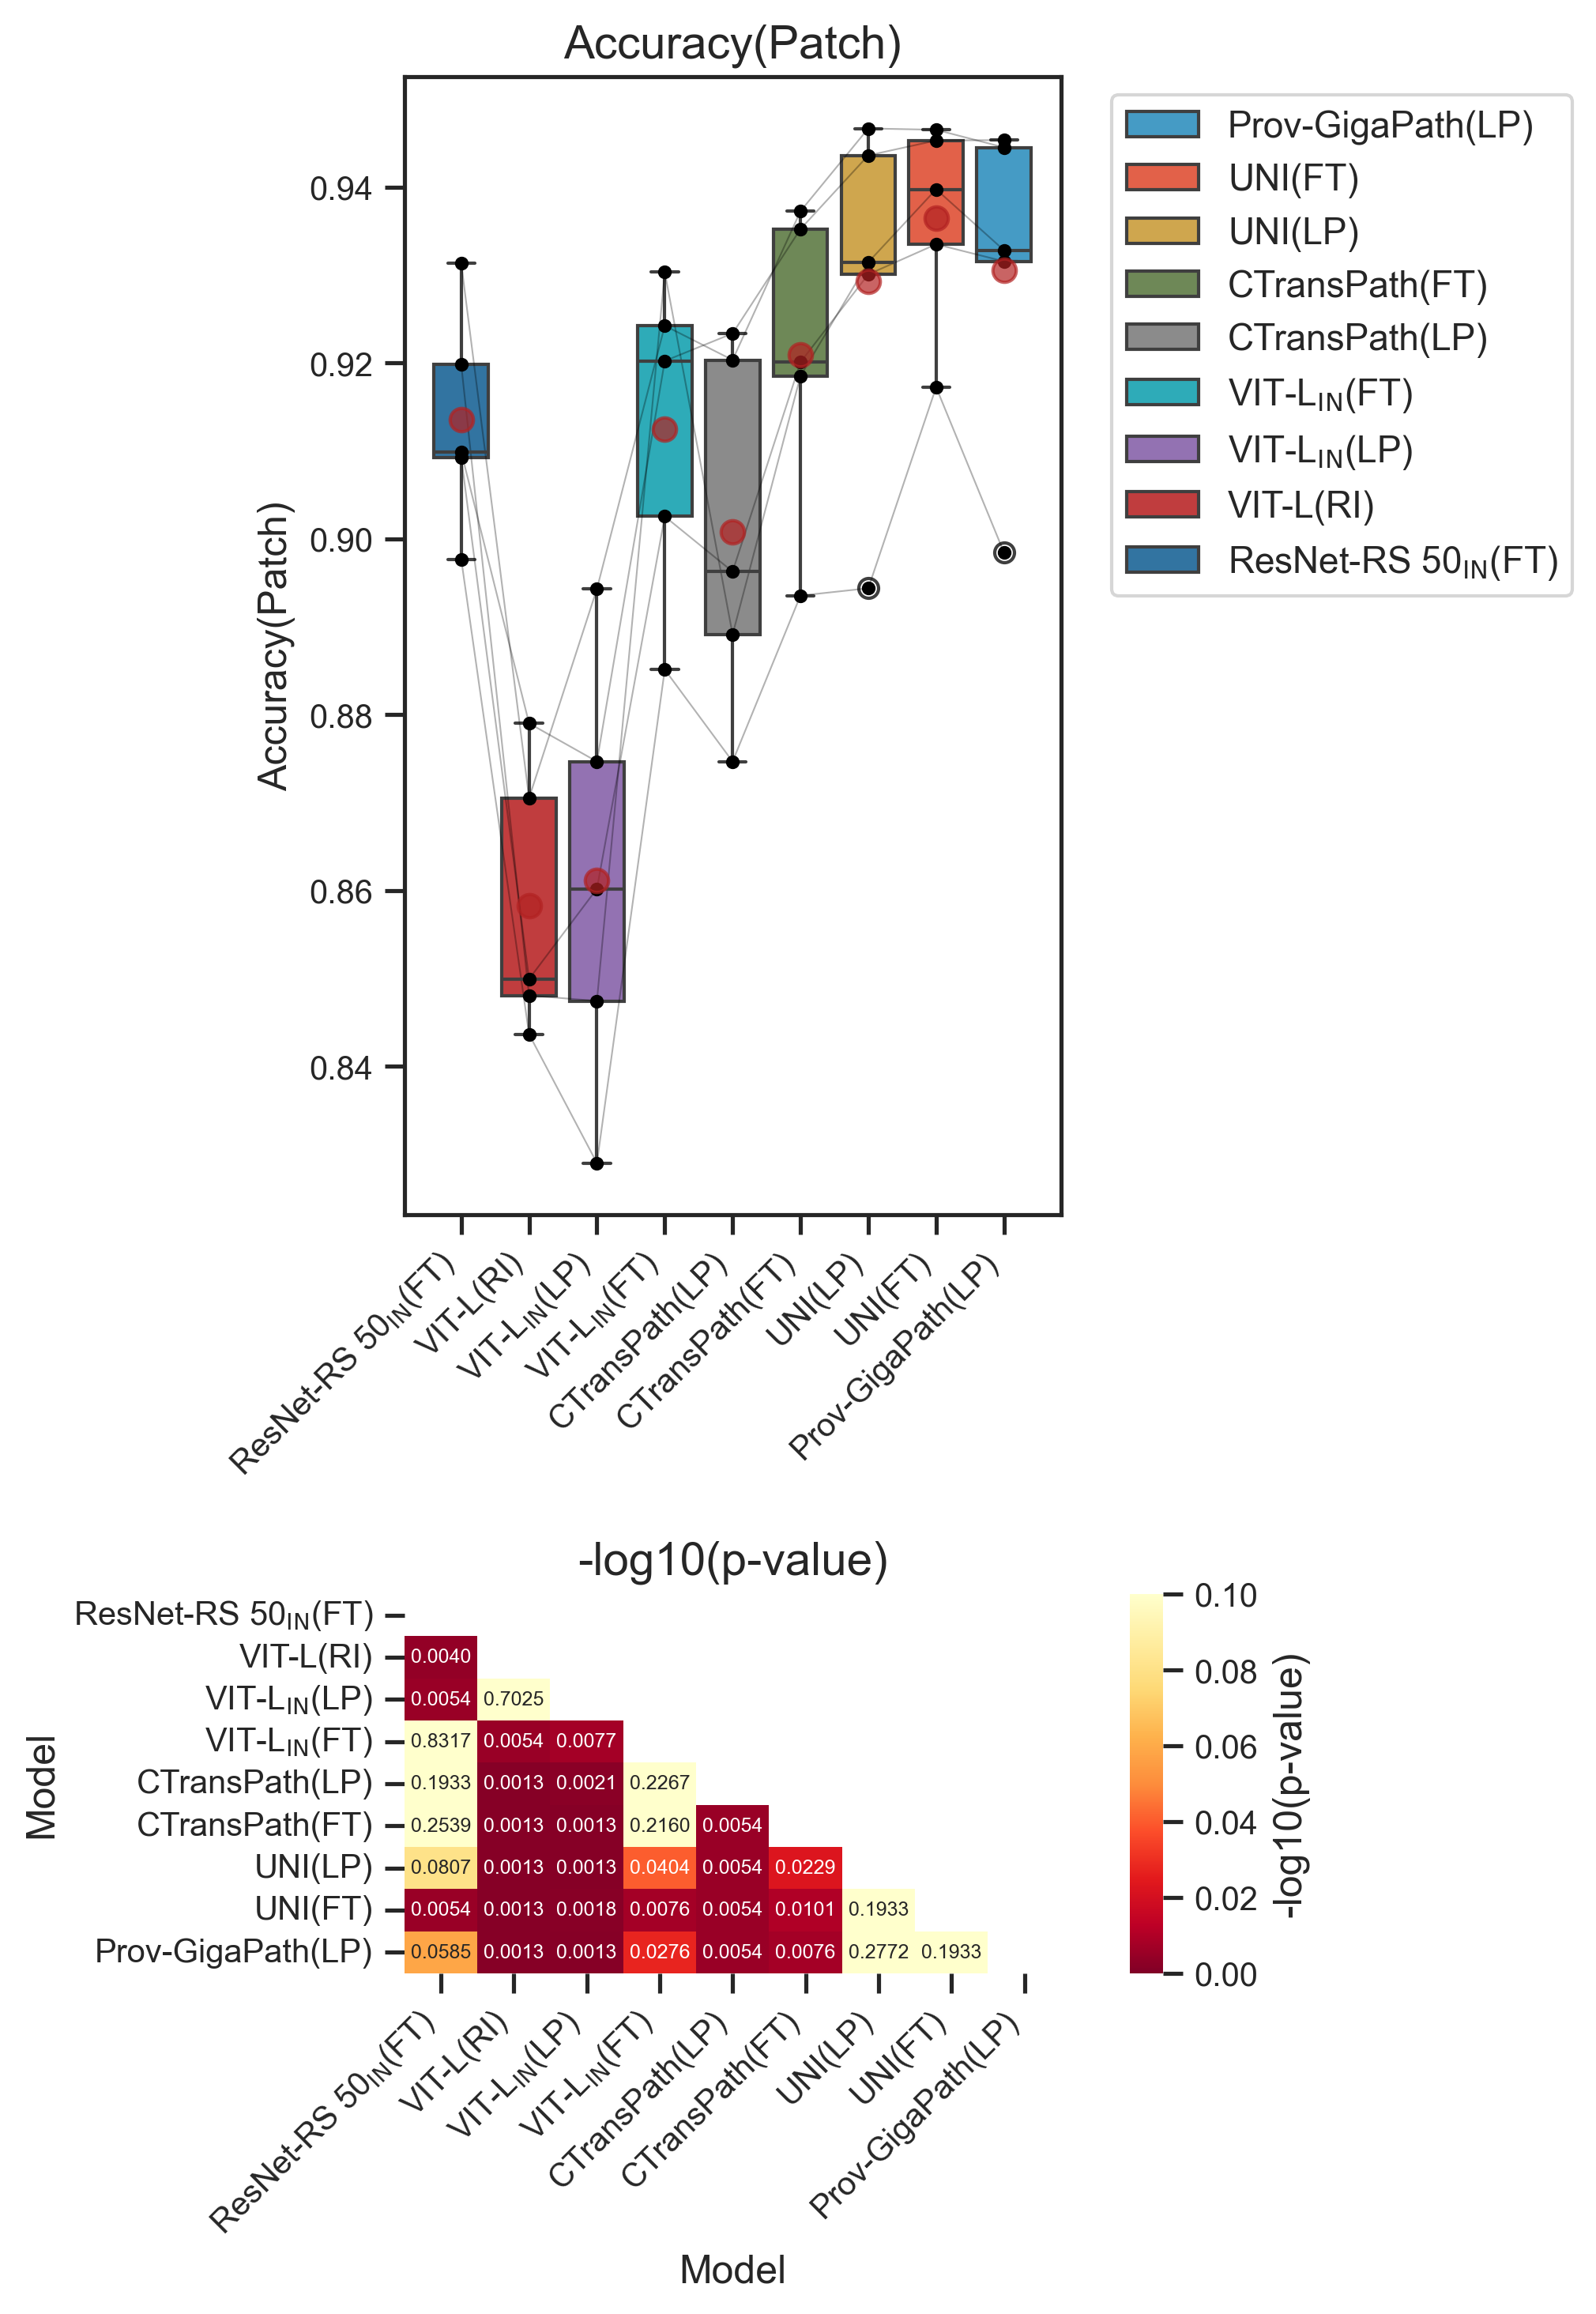

cv - fine - 500 - recall
saved out/figs/box_cv_fine_500_recall.png


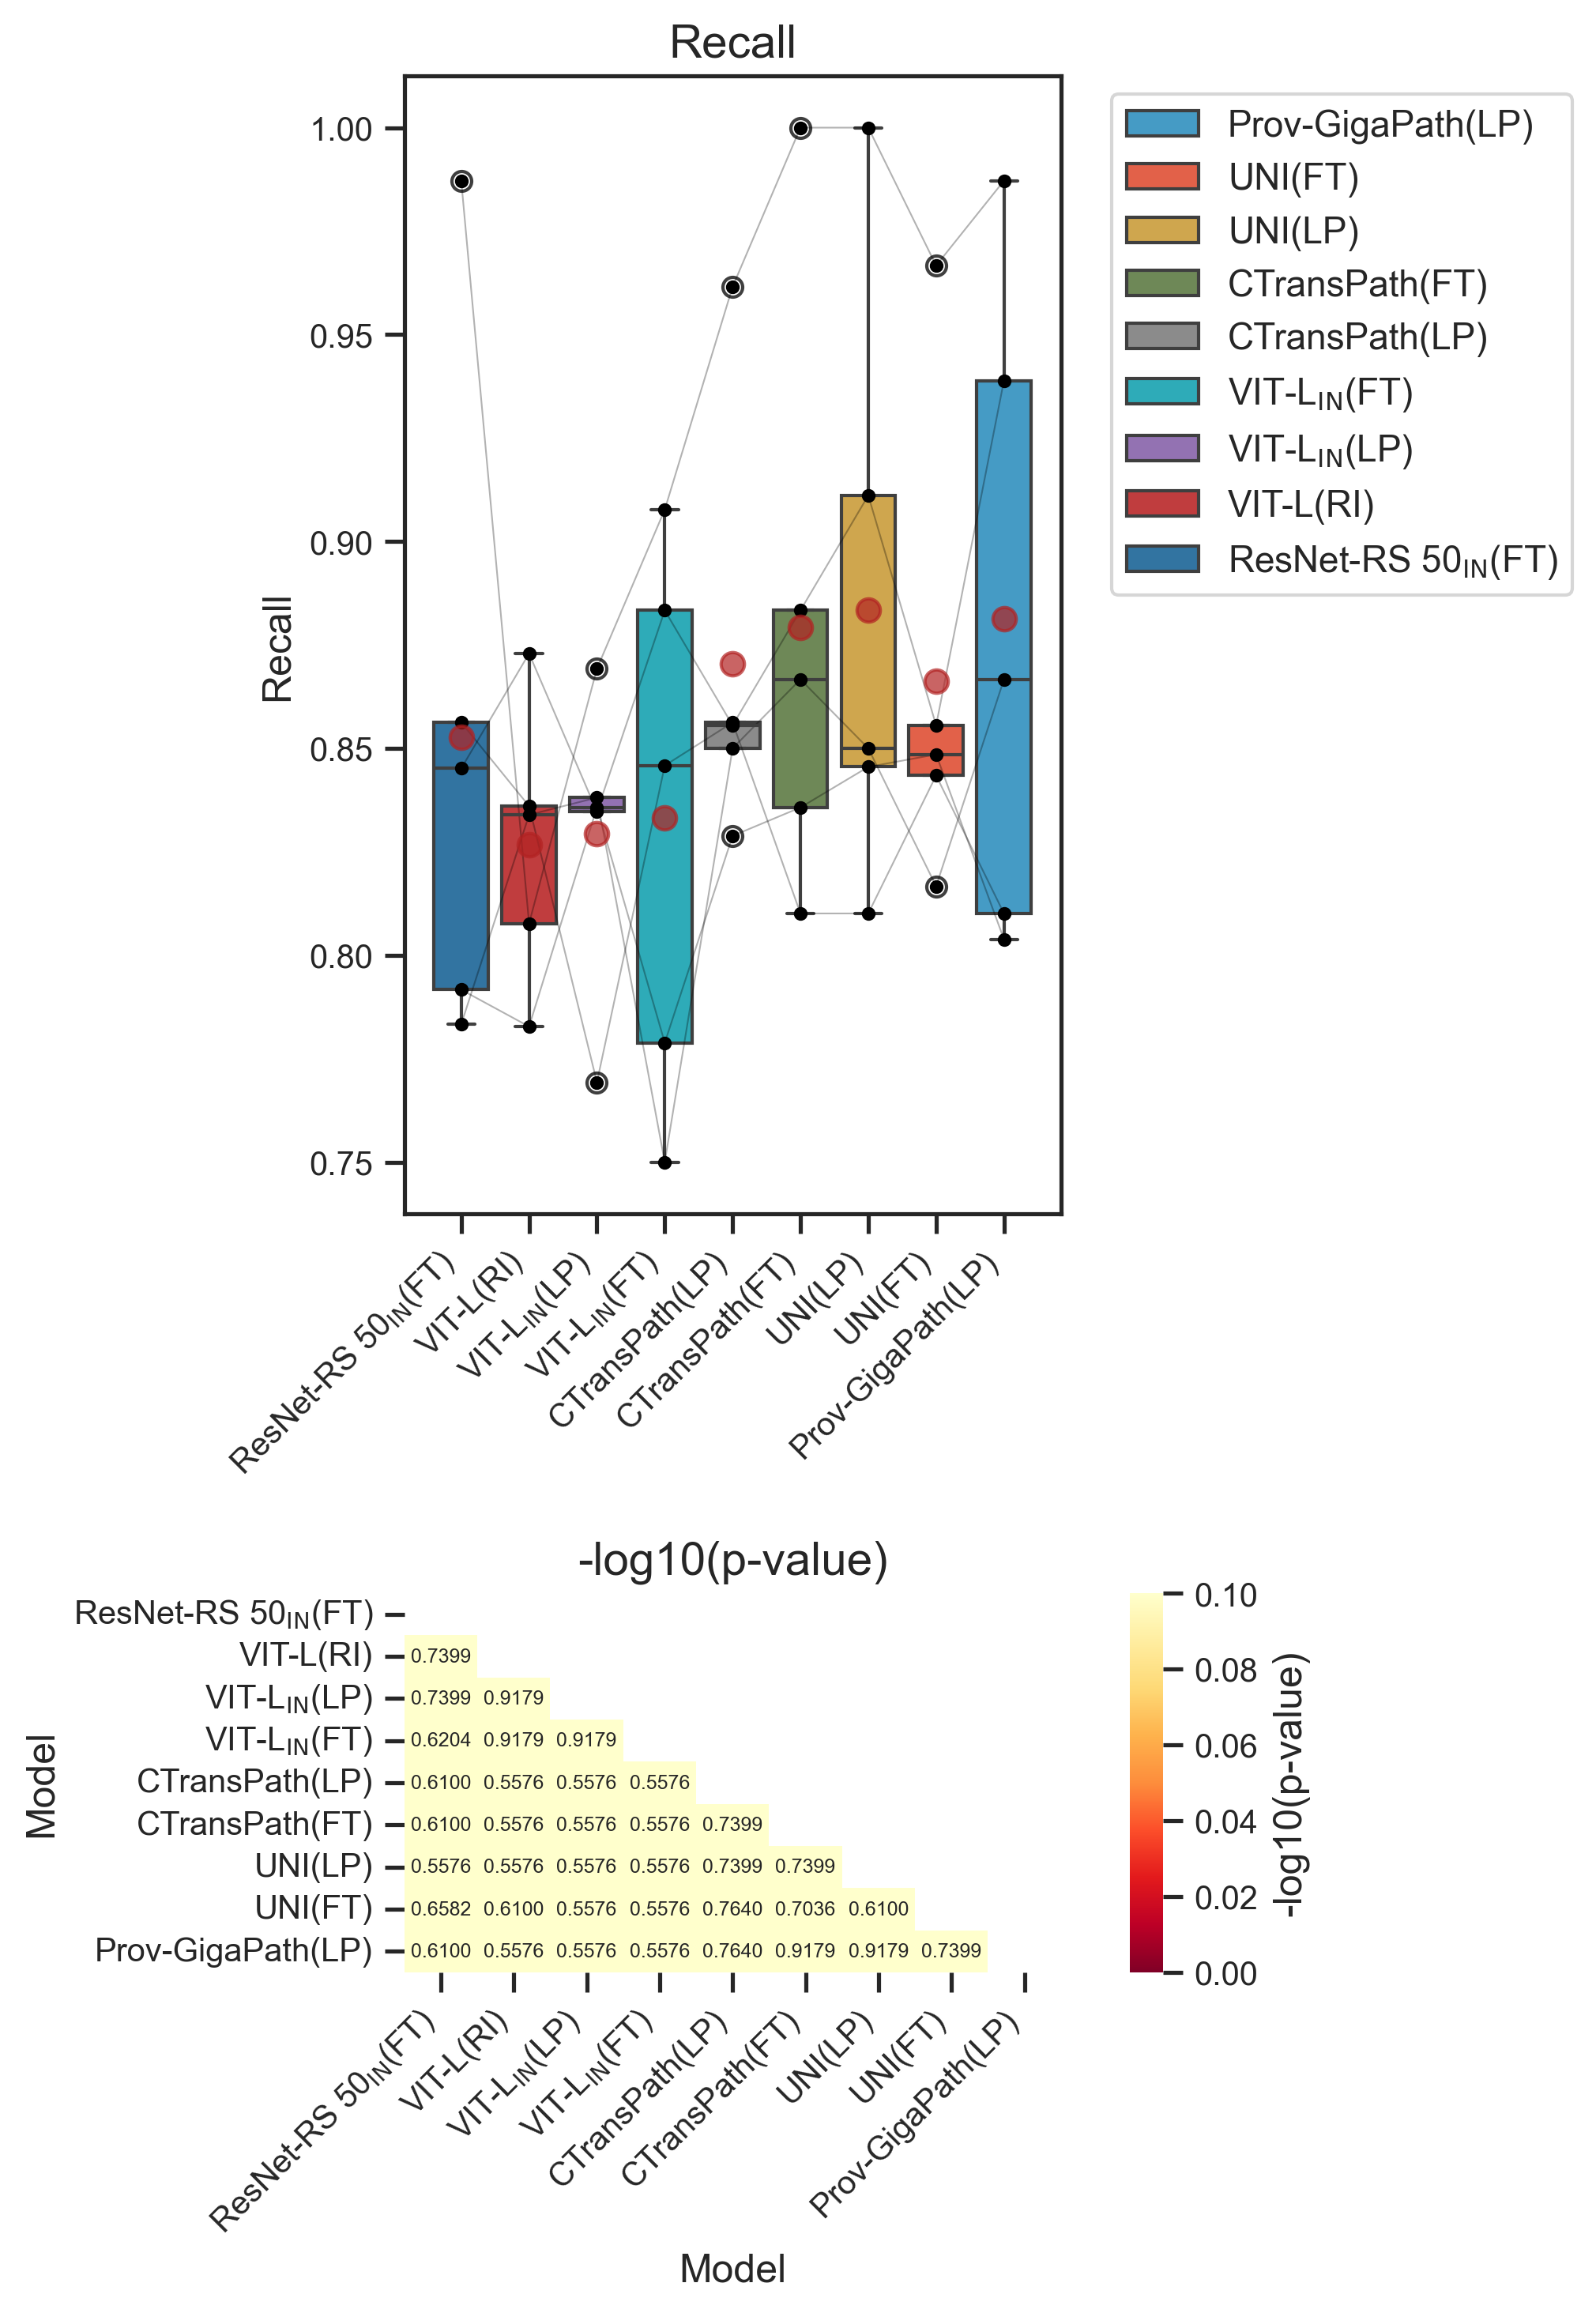

cv - fine - 500 - acc
saved out/figs/box_cv_fine_500_acc.png
cv - fine - 500 - f1
saved out/figs/box_cv_fine_500_f1.png
ebrains - fine - 500 - pacc
saved out/figs/box_ebrains_fine_500_pacc.png


ebrains - fine - 500 - recall
saved out/figs/box_ebrains_fine_500_recall.png


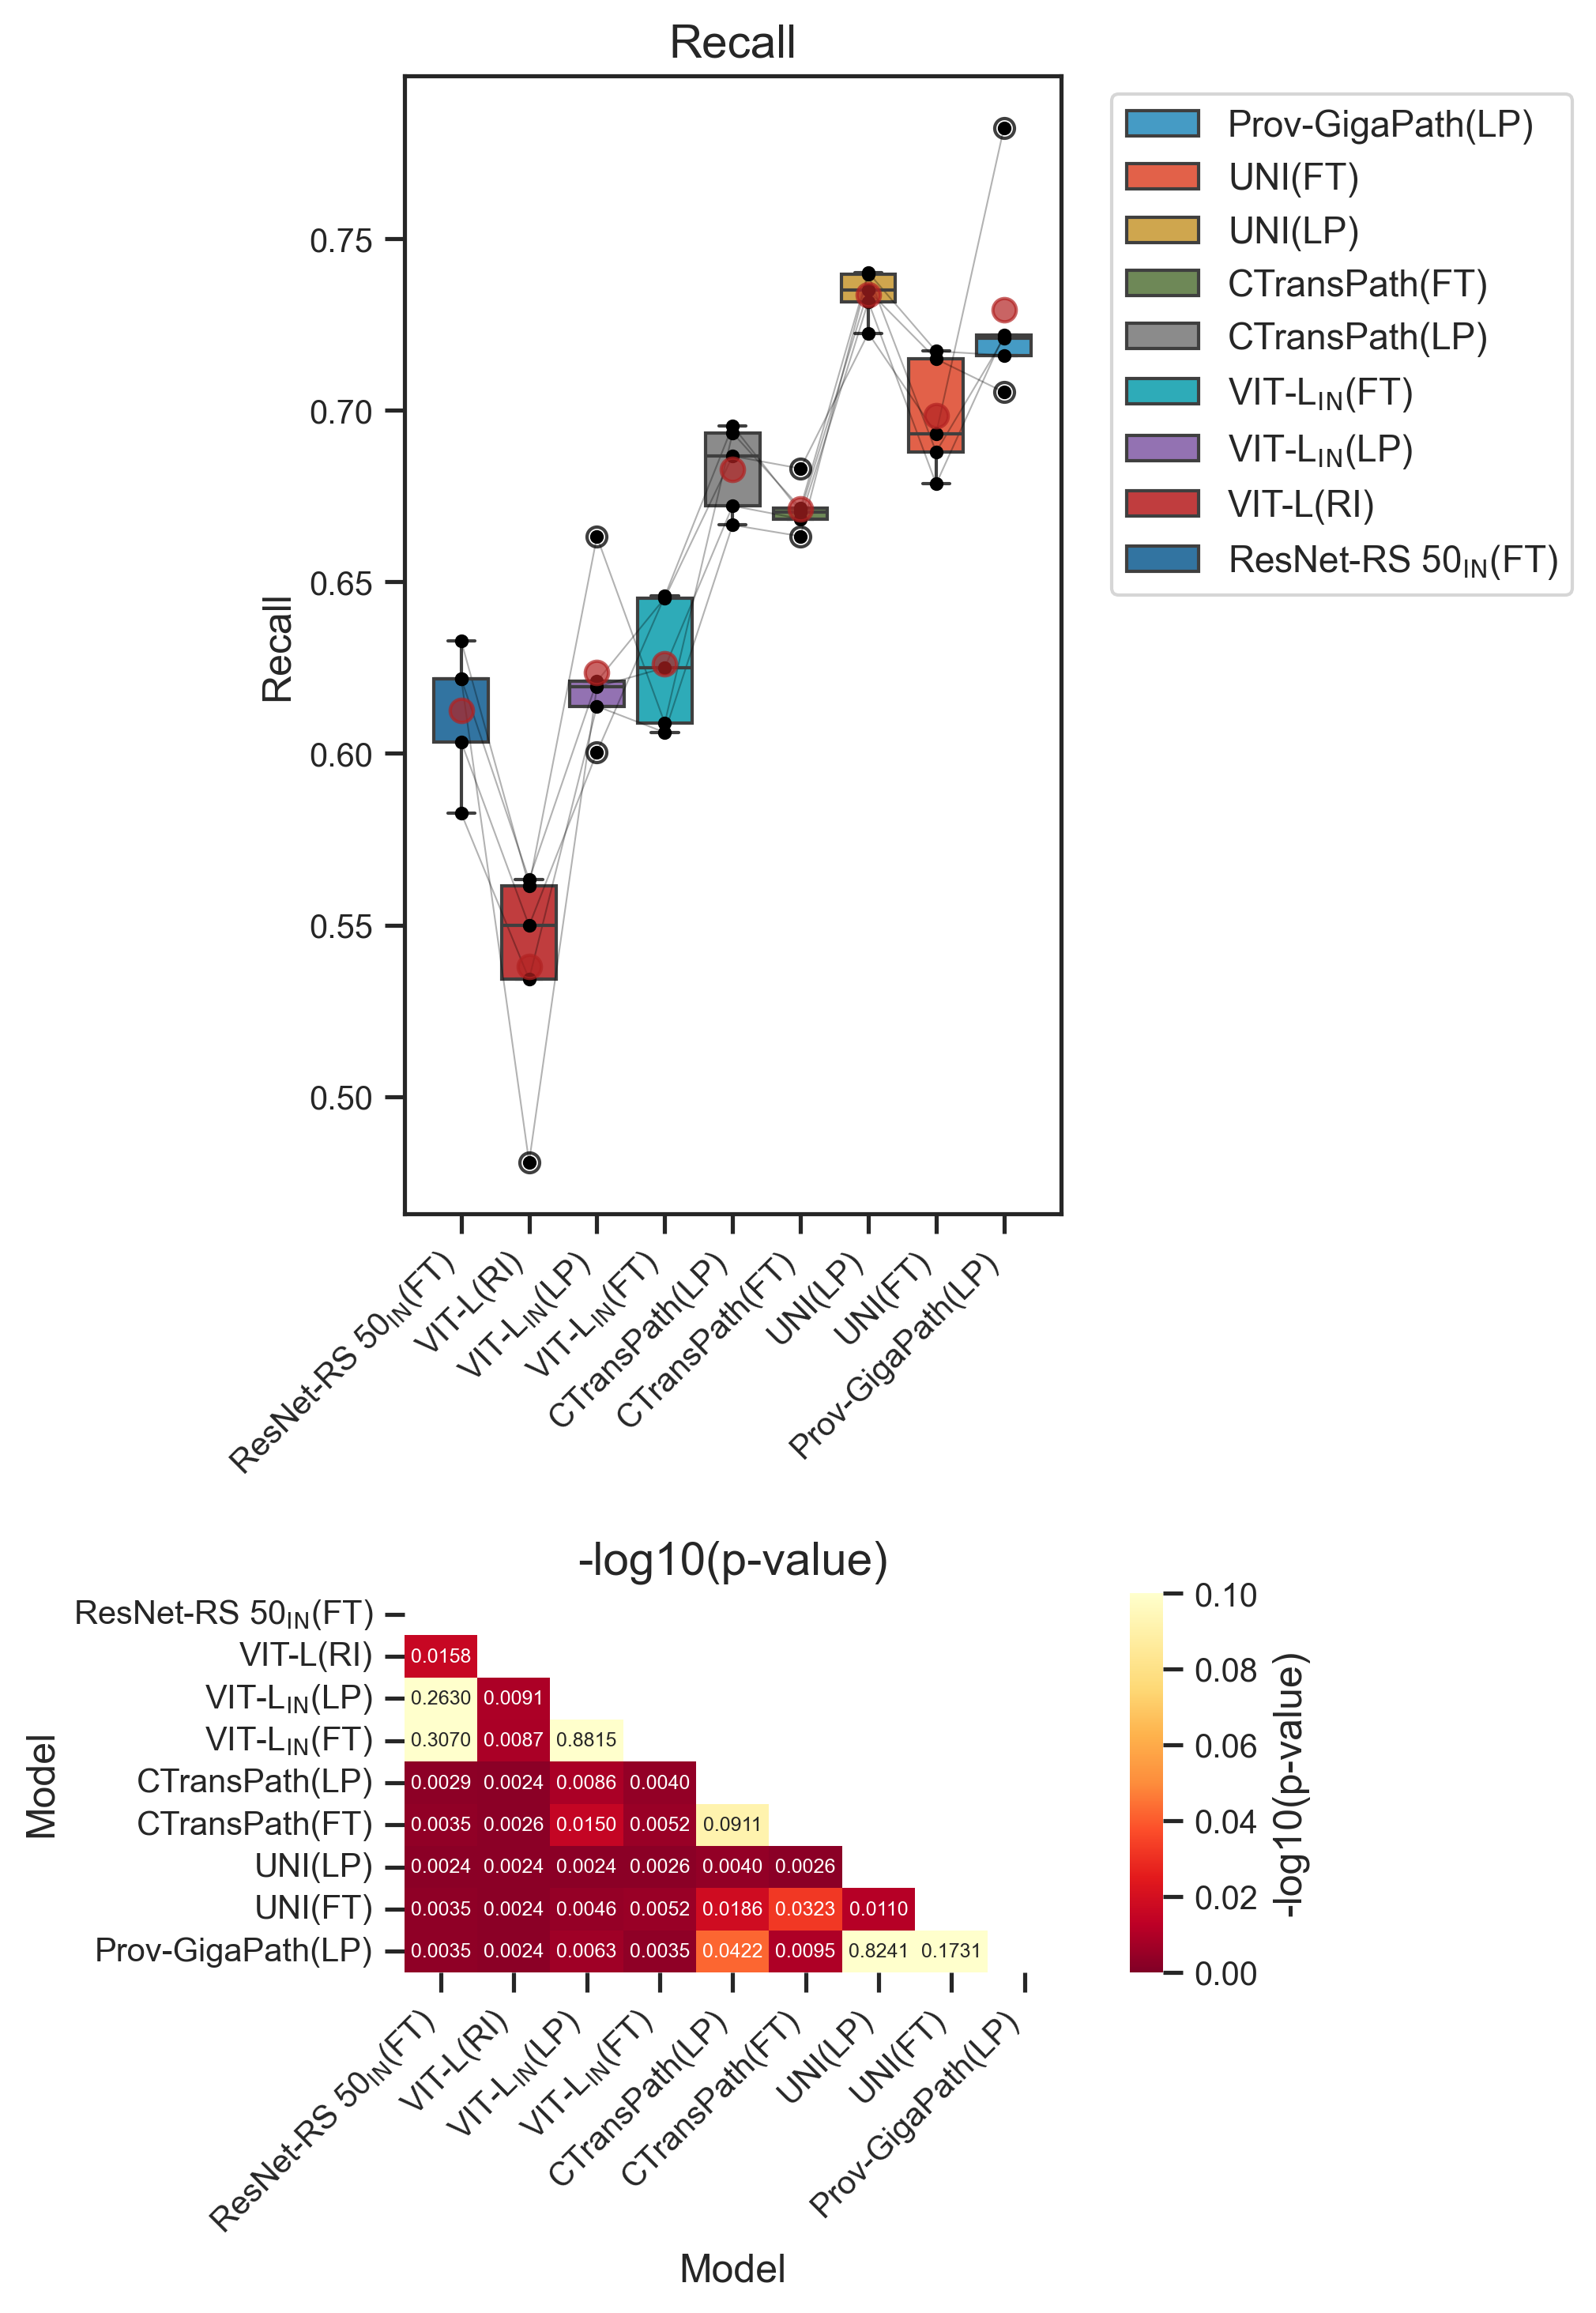

ebrains - fine - 500 - acc
saved out/figs/box_ebrains_fine_500_acc.png
ebrains - fine - 500 - f1
saved out/figs/box_ebrains_fine_500_f1.png


In [36]:
paired_box('cv', False, LIMIT, 'pacc', True)
paired_box('cv', False, LIMIT, 'recall', True)
paired_box('cv', False, LIMIT, 'acc')
paired_box('cv', False, LIMIT, 'f1')

paired_box('ebrains', False, LIMIT, 'pacc', True)
paired_box('ebrains', False, LIMIT, 'recall', True)
paired_box('ebrains', False, LIMIT, 'acc')
paired_box('ebrains', False, LIMIT, 'f1')

### EBRAINS 500 fine patches/case

cv - coarse - 500 - pacc
saved out/figs/box_cv_coarse_500_pacc.png


cv - coarse - 500 - recall
saved out/figs/box_cv_coarse_500_recall.png


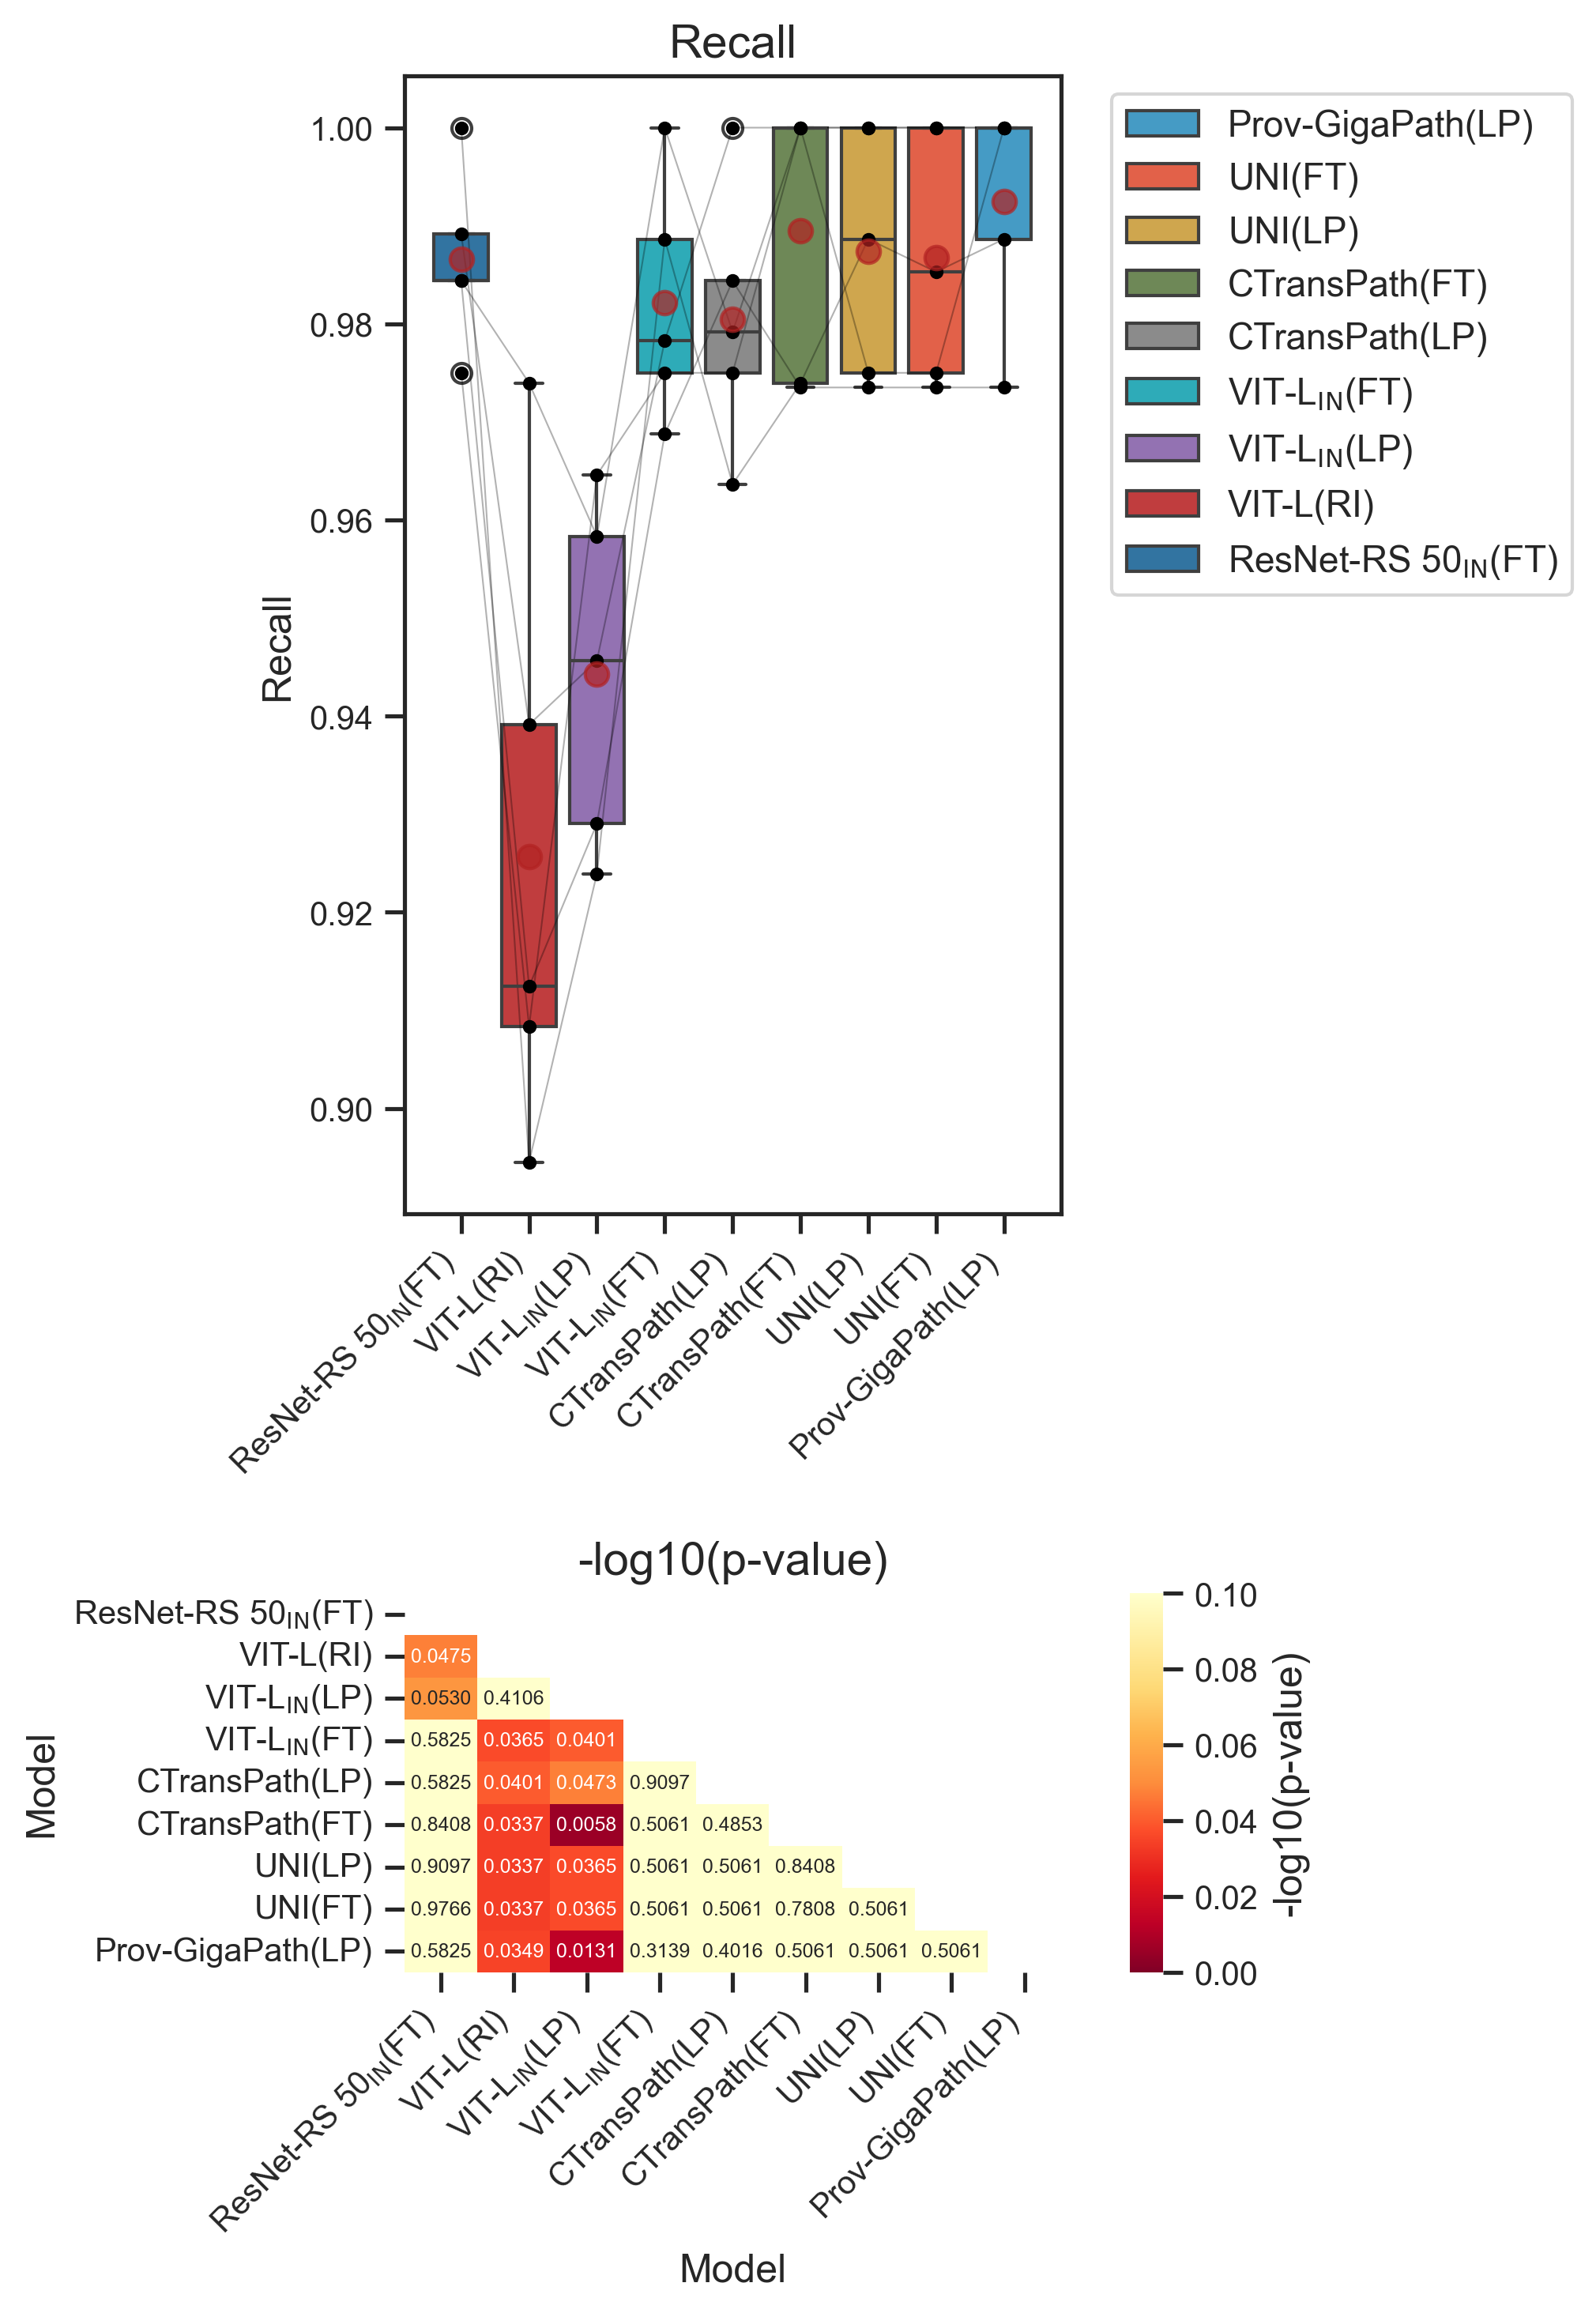

cv - coarse - 500 - acc
saved out/figs/box_cv_coarse_500_acc.png
cv - coarse - 500 - f1
saved out/figs/box_cv_coarse_500_f1.png
ebrains - coarse - 500 - pacc
saved out/figs/box_ebrains_coarse_500_pacc.png


ebrains - coarse - 500 - recall
saved out/figs/box_ebrains_coarse_500_recall.png


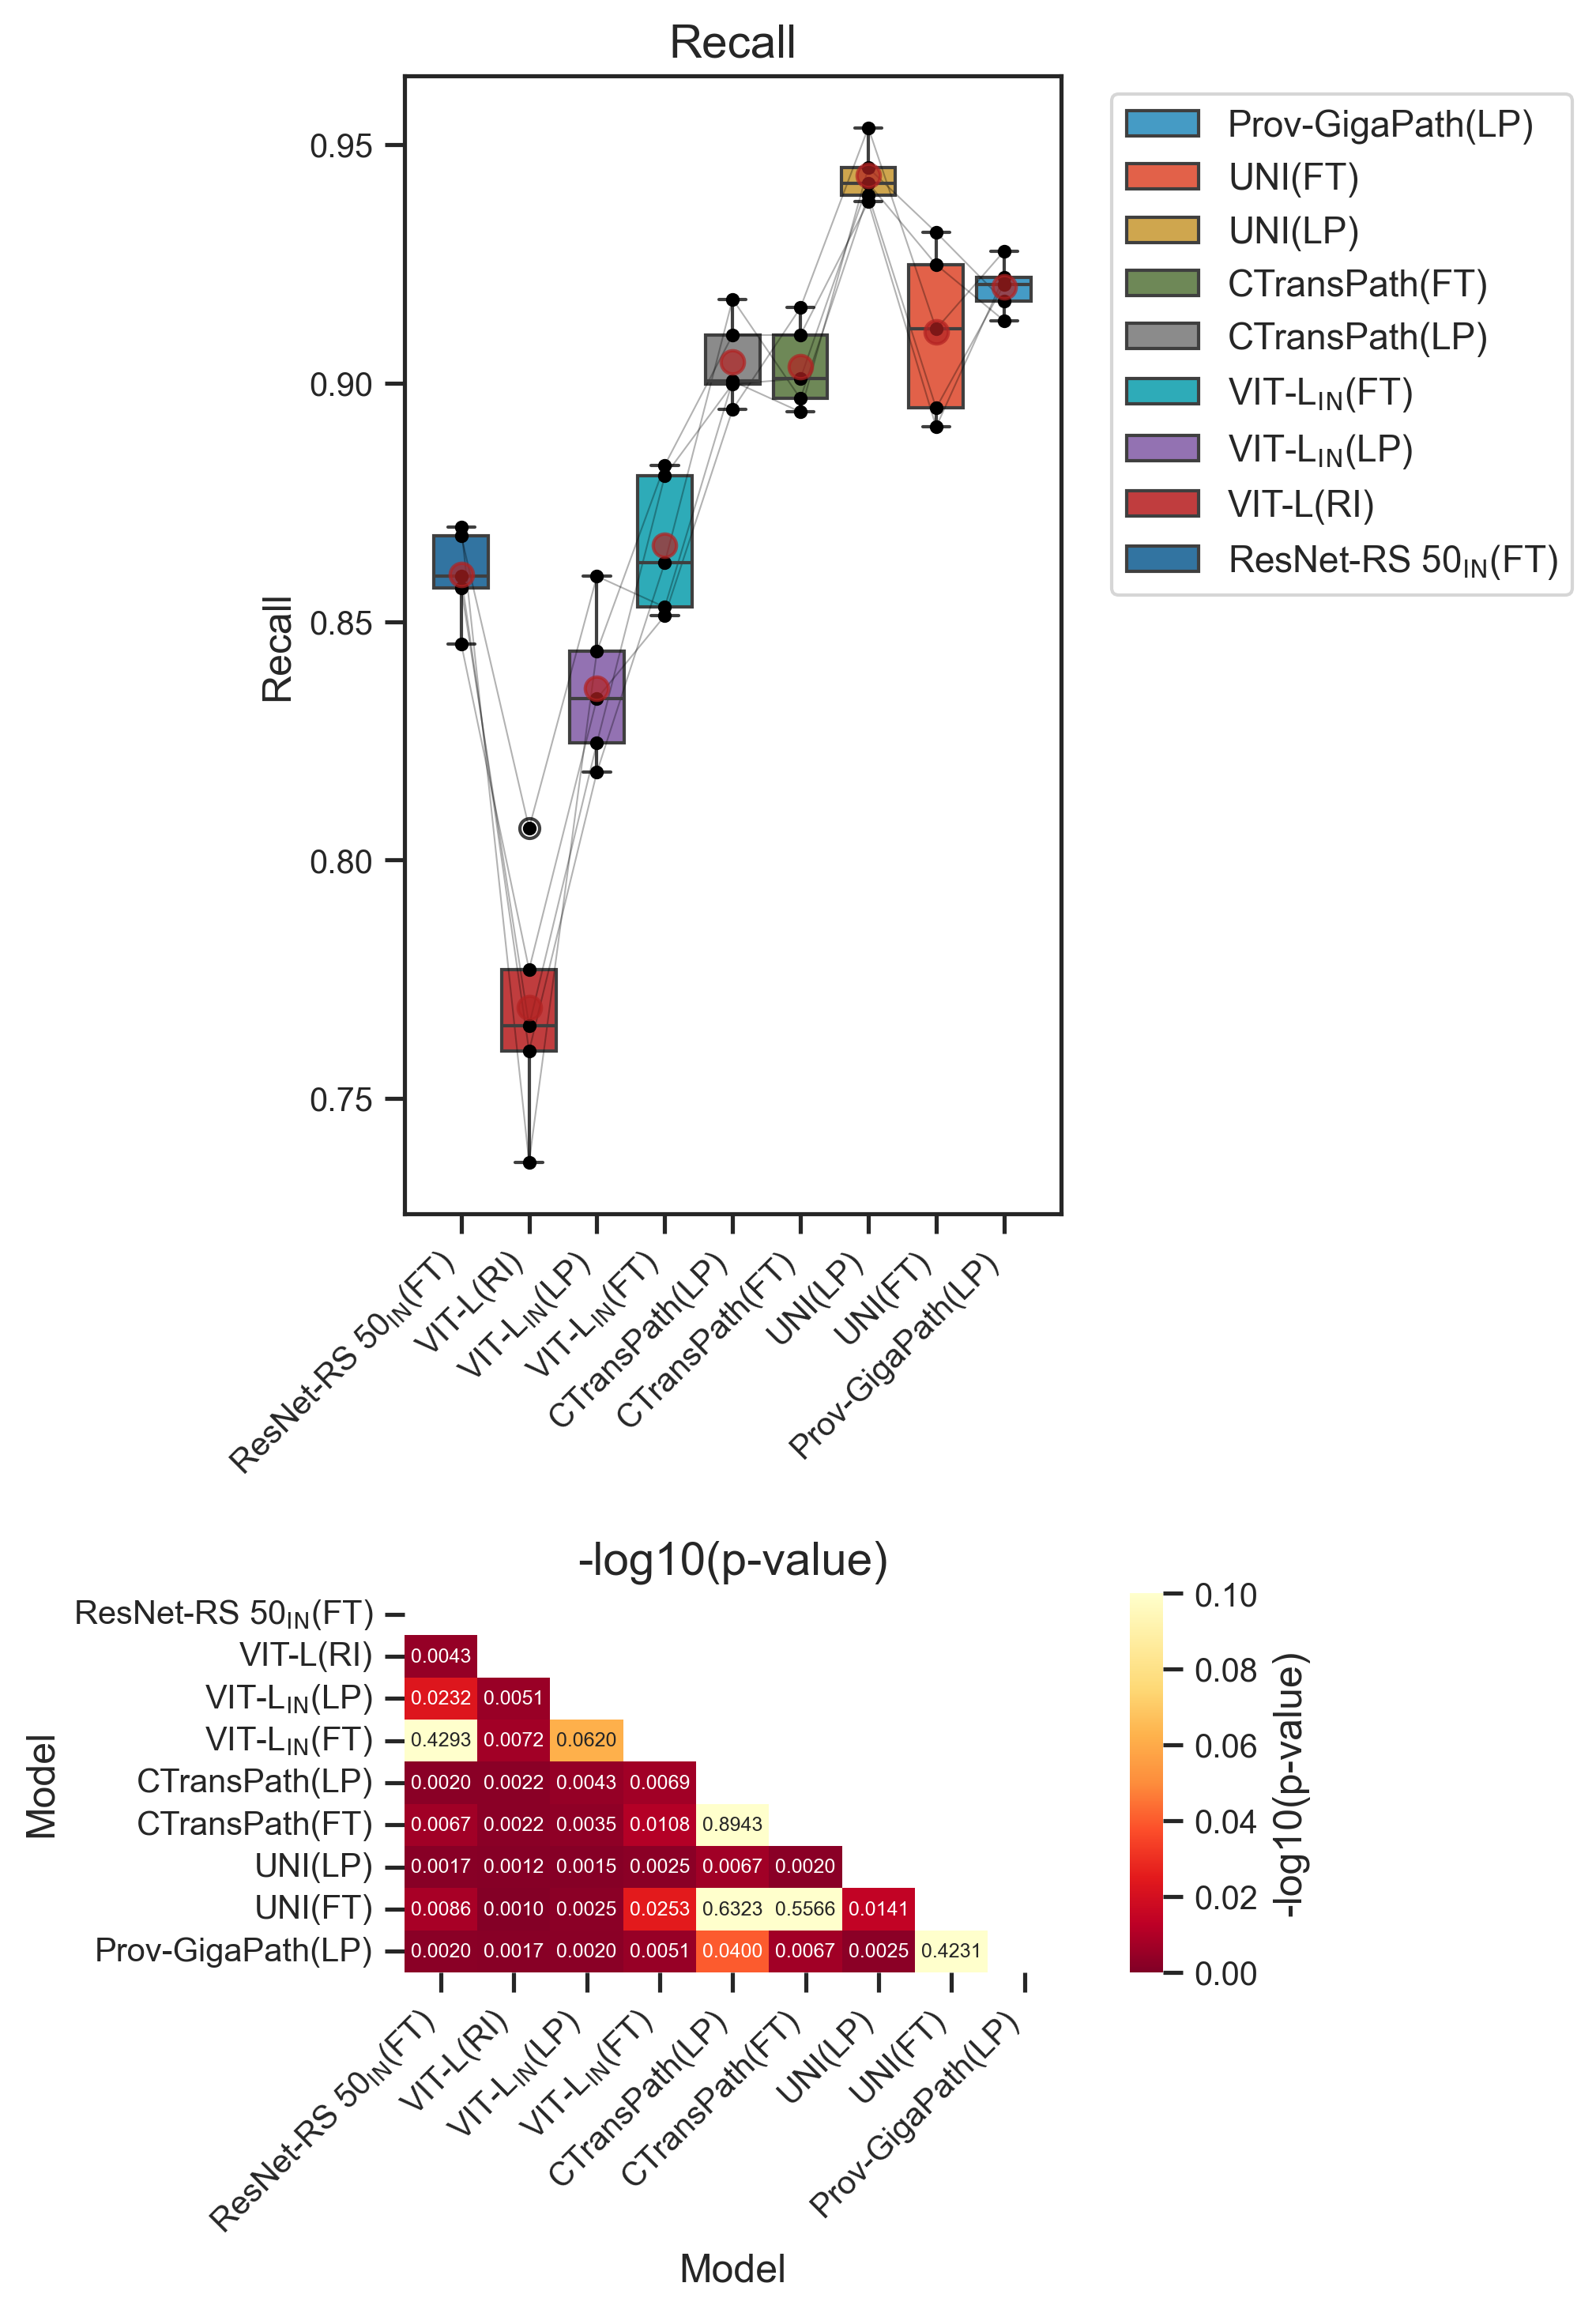

ebrains - coarse - 500 - acc
saved out/figs/box_ebrains_coarse_500_acc.png
ebrains - coarse - 500 - f1
saved out/figs/box_ebrains_coarse_500_f1.png


In [37]:
paired_box('cv', True, LIMIT, 'pacc', True)
paired_box('cv', True, LIMIT, 'recall', True)
paired_box('cv', True, LIMIT, 'acc')
paired_box('cv', True, LIMIT, 'f1')

paired_box('ebrains', True, LIMIT, 'pacc', True)
paired_box('ebrains', True, LIMIT, 'recall', True)
paired_box('ebrains', True, LIMIT, 'acc')
paired_box('ebrains', True, LIMIT, 'f1')

#### fig4

This fig shows the impact of patch number per case on model performace

In [11]:
def draw_lines(target, key:str, coarse:bool, fill=False, show=False):
    labels = [
        r'Prov-GigaPath(LP)',
        r'UNI(FT)',
        r'UNI(LP)',
        r'CTransPath(FT)',
        r'CTransPath(LP)',
        r'VIT-L$\mathrm{_{IN}}$(FT)',
        r'VIT-L$\mathrm{_{IN}}$(LP)',
        r'VIT-L(RI)',
        r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
        # r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    ]

    grains = 'coarse' if coarse else 'fine'
    key_label = {
        'pacc': 'Accuracy(Patch)',
        'recall': 'Recall',
        'acc': 'Accuracy',
        'f1': 'F1 score',
    }[key]
    
    # color_map = dict(zip((label_order), plt.cm.Set2(np.linspace(0, 1, len(label_order)))))
    # color_map = dict(zip(label_order, sns.color_palette(PALETTE, n_colors=len(label_order))))
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        # if labels is None:
        #     if limit == limits[0]:
        #         # sort on 10 limit
        #         df_mean = df.groupby('label')[key].mean().sort_values(ascending=True)
        #         df[f'average_{key}'] = df['label'].map(df_mean)
        #         df = df.sort_values([f'average_{key}', 'fold'], ascending=[True, True])
        #         labels = df['label'].unique()[::-1]

        for label in labels:
            scores = df[df['label']==label][key_label]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            # CI
            # diff = stats.t.interval(1 - alpha, df=len(scores)-1, loc=mean, scale=diff)[1] - mean
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    plt.figure(figsize=(6, 7))
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        plt.plot(x, values_by_cond[i, :, 0], color=c, label=label)
        if fill:
            plt.fill_between(x, ci_l, ci_h, color=c, alpha=0.1)
    
    plt.xticks(x, limits)
    plt.xlabel('Patch count per case')
    plt.ylabel(key_label)
    # plt.legend(loc='lower right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(key_label)    
    plt.tight_layout()
    fig_path = f'out/figs/lines_{target}_{grains}_{key}.png'
    plt.savefig(fig_path, format="png", dpi=DPI)
    print(f'wrote {fig_path}')
    if show:
        plt.show()
    else:
        plt.close()



wrote out/figs/lines_cv_fine_pacc.png


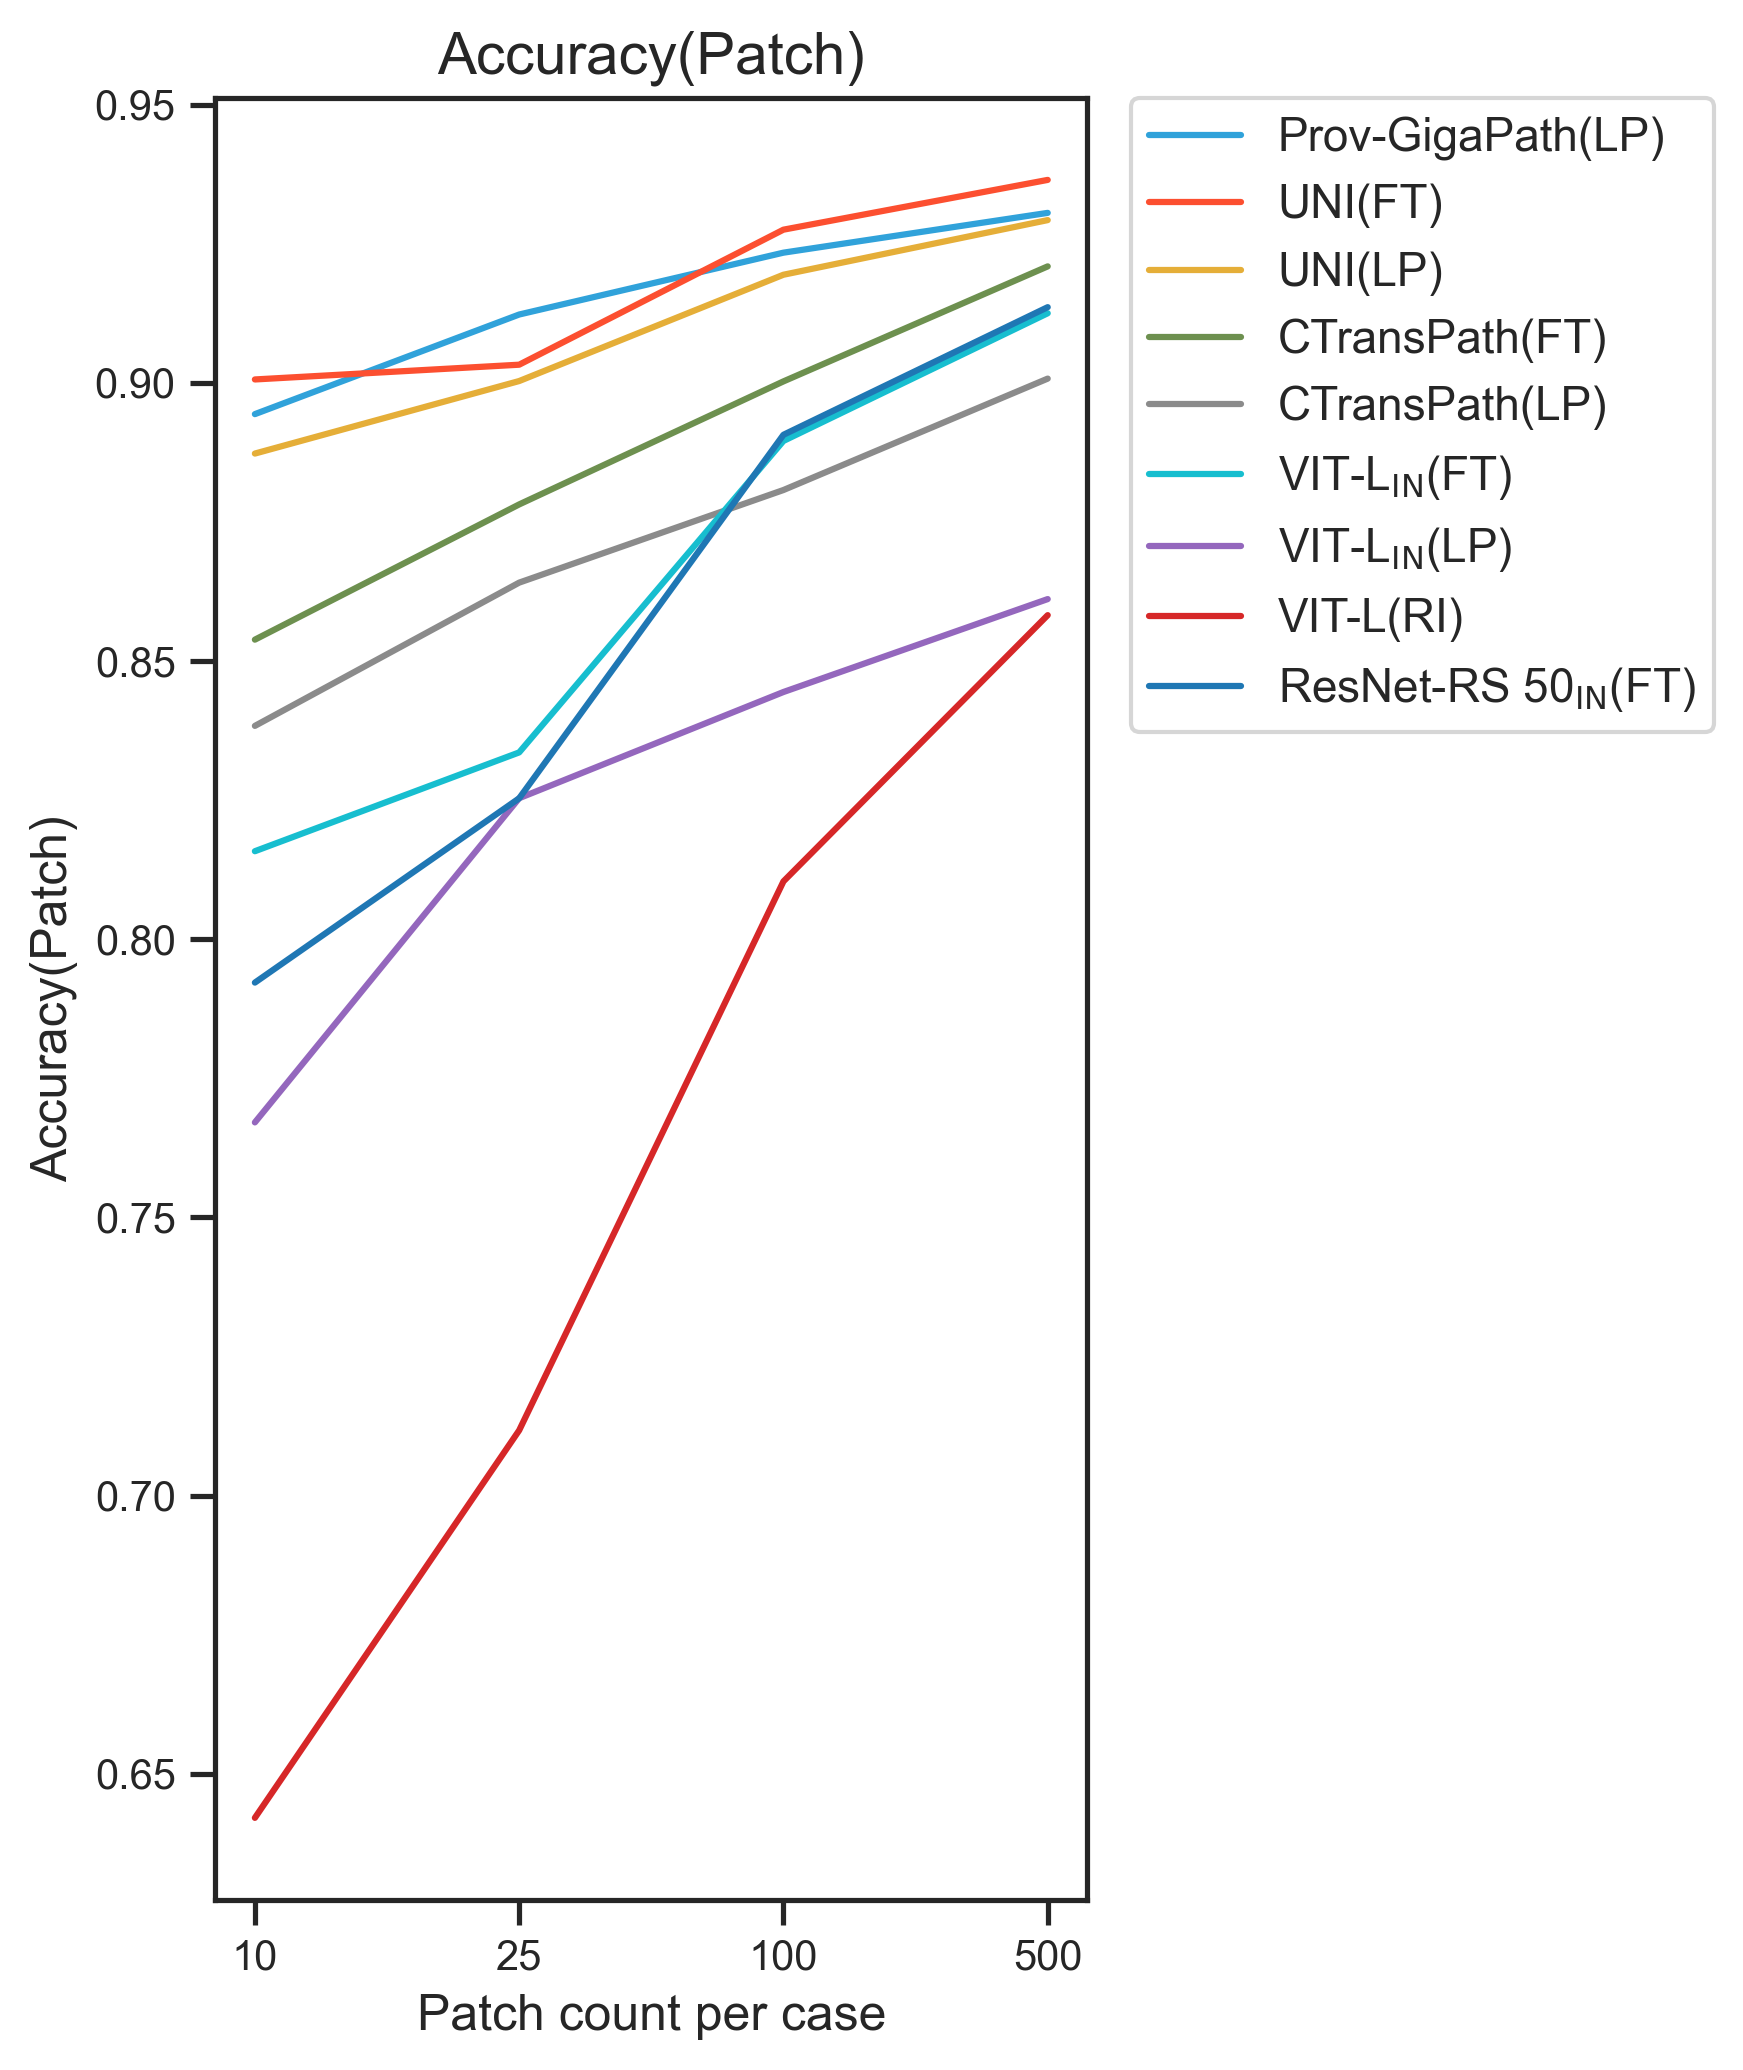

wrote out/figs/lines_cv_fine_recall.png


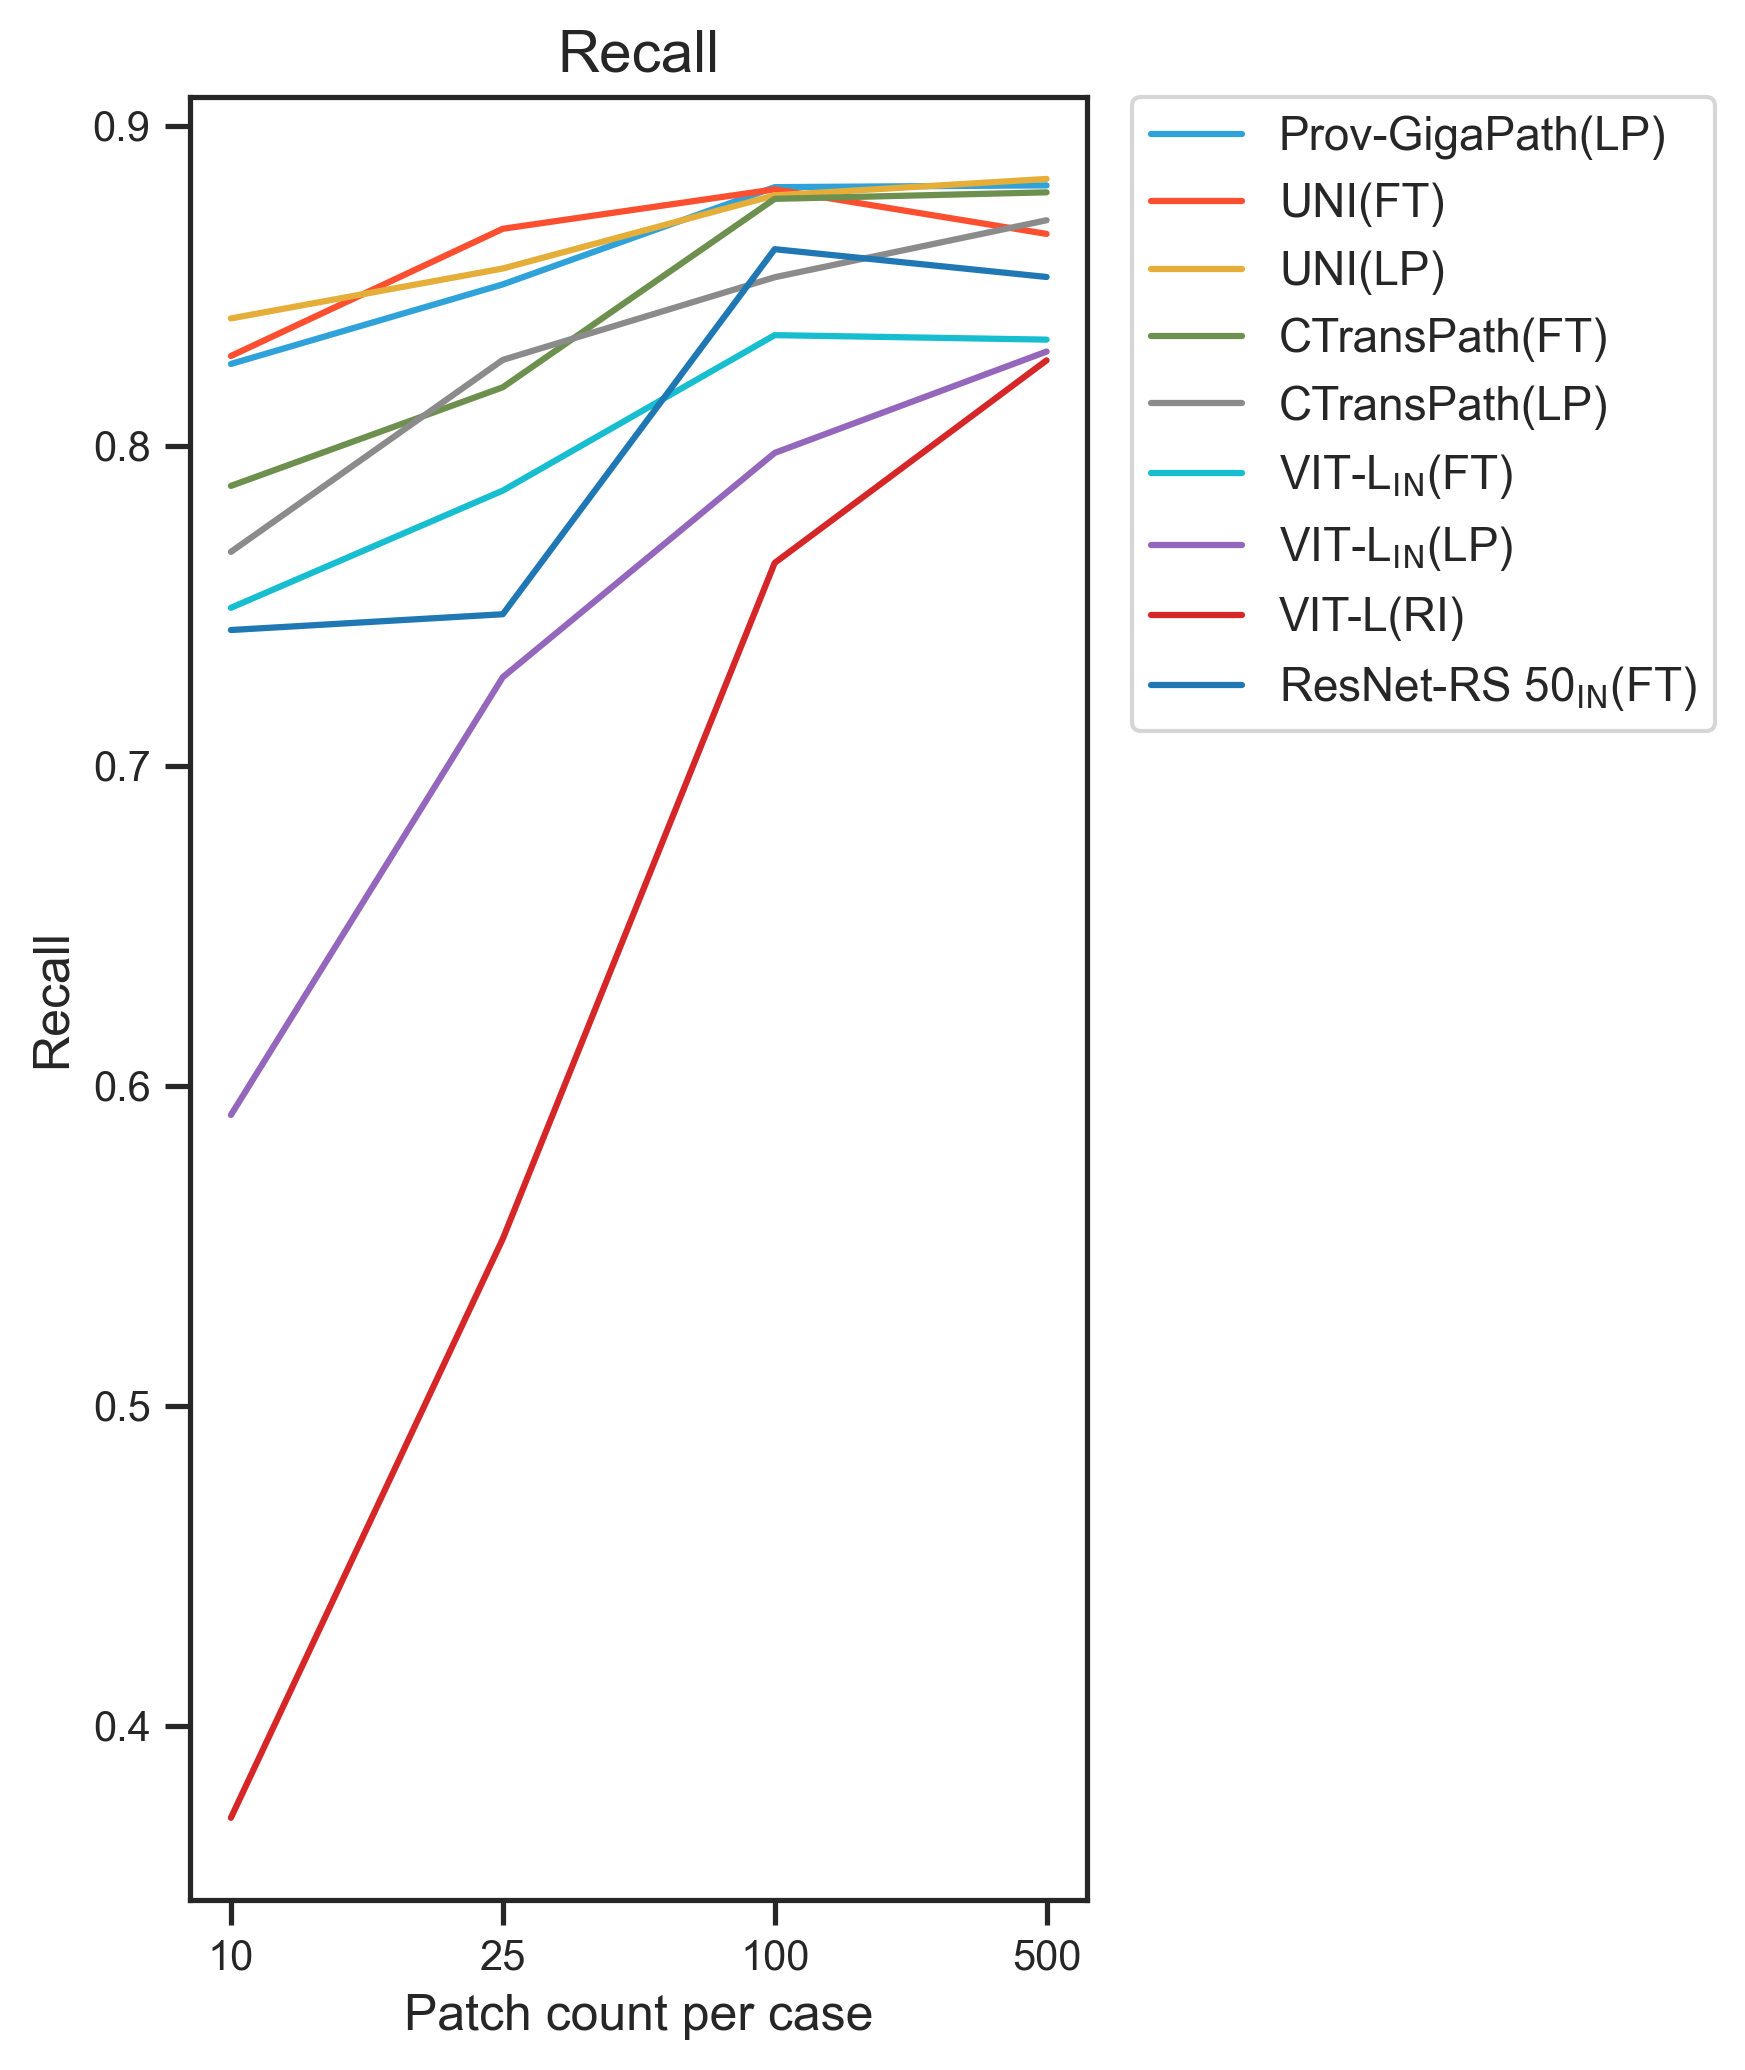

wrote out/figs/lines_cv_fine_acc.png
wrote out/figs/lines_cv_fine_f1.png
wrote out/figs/lines_ebrains_fine_pacc.png


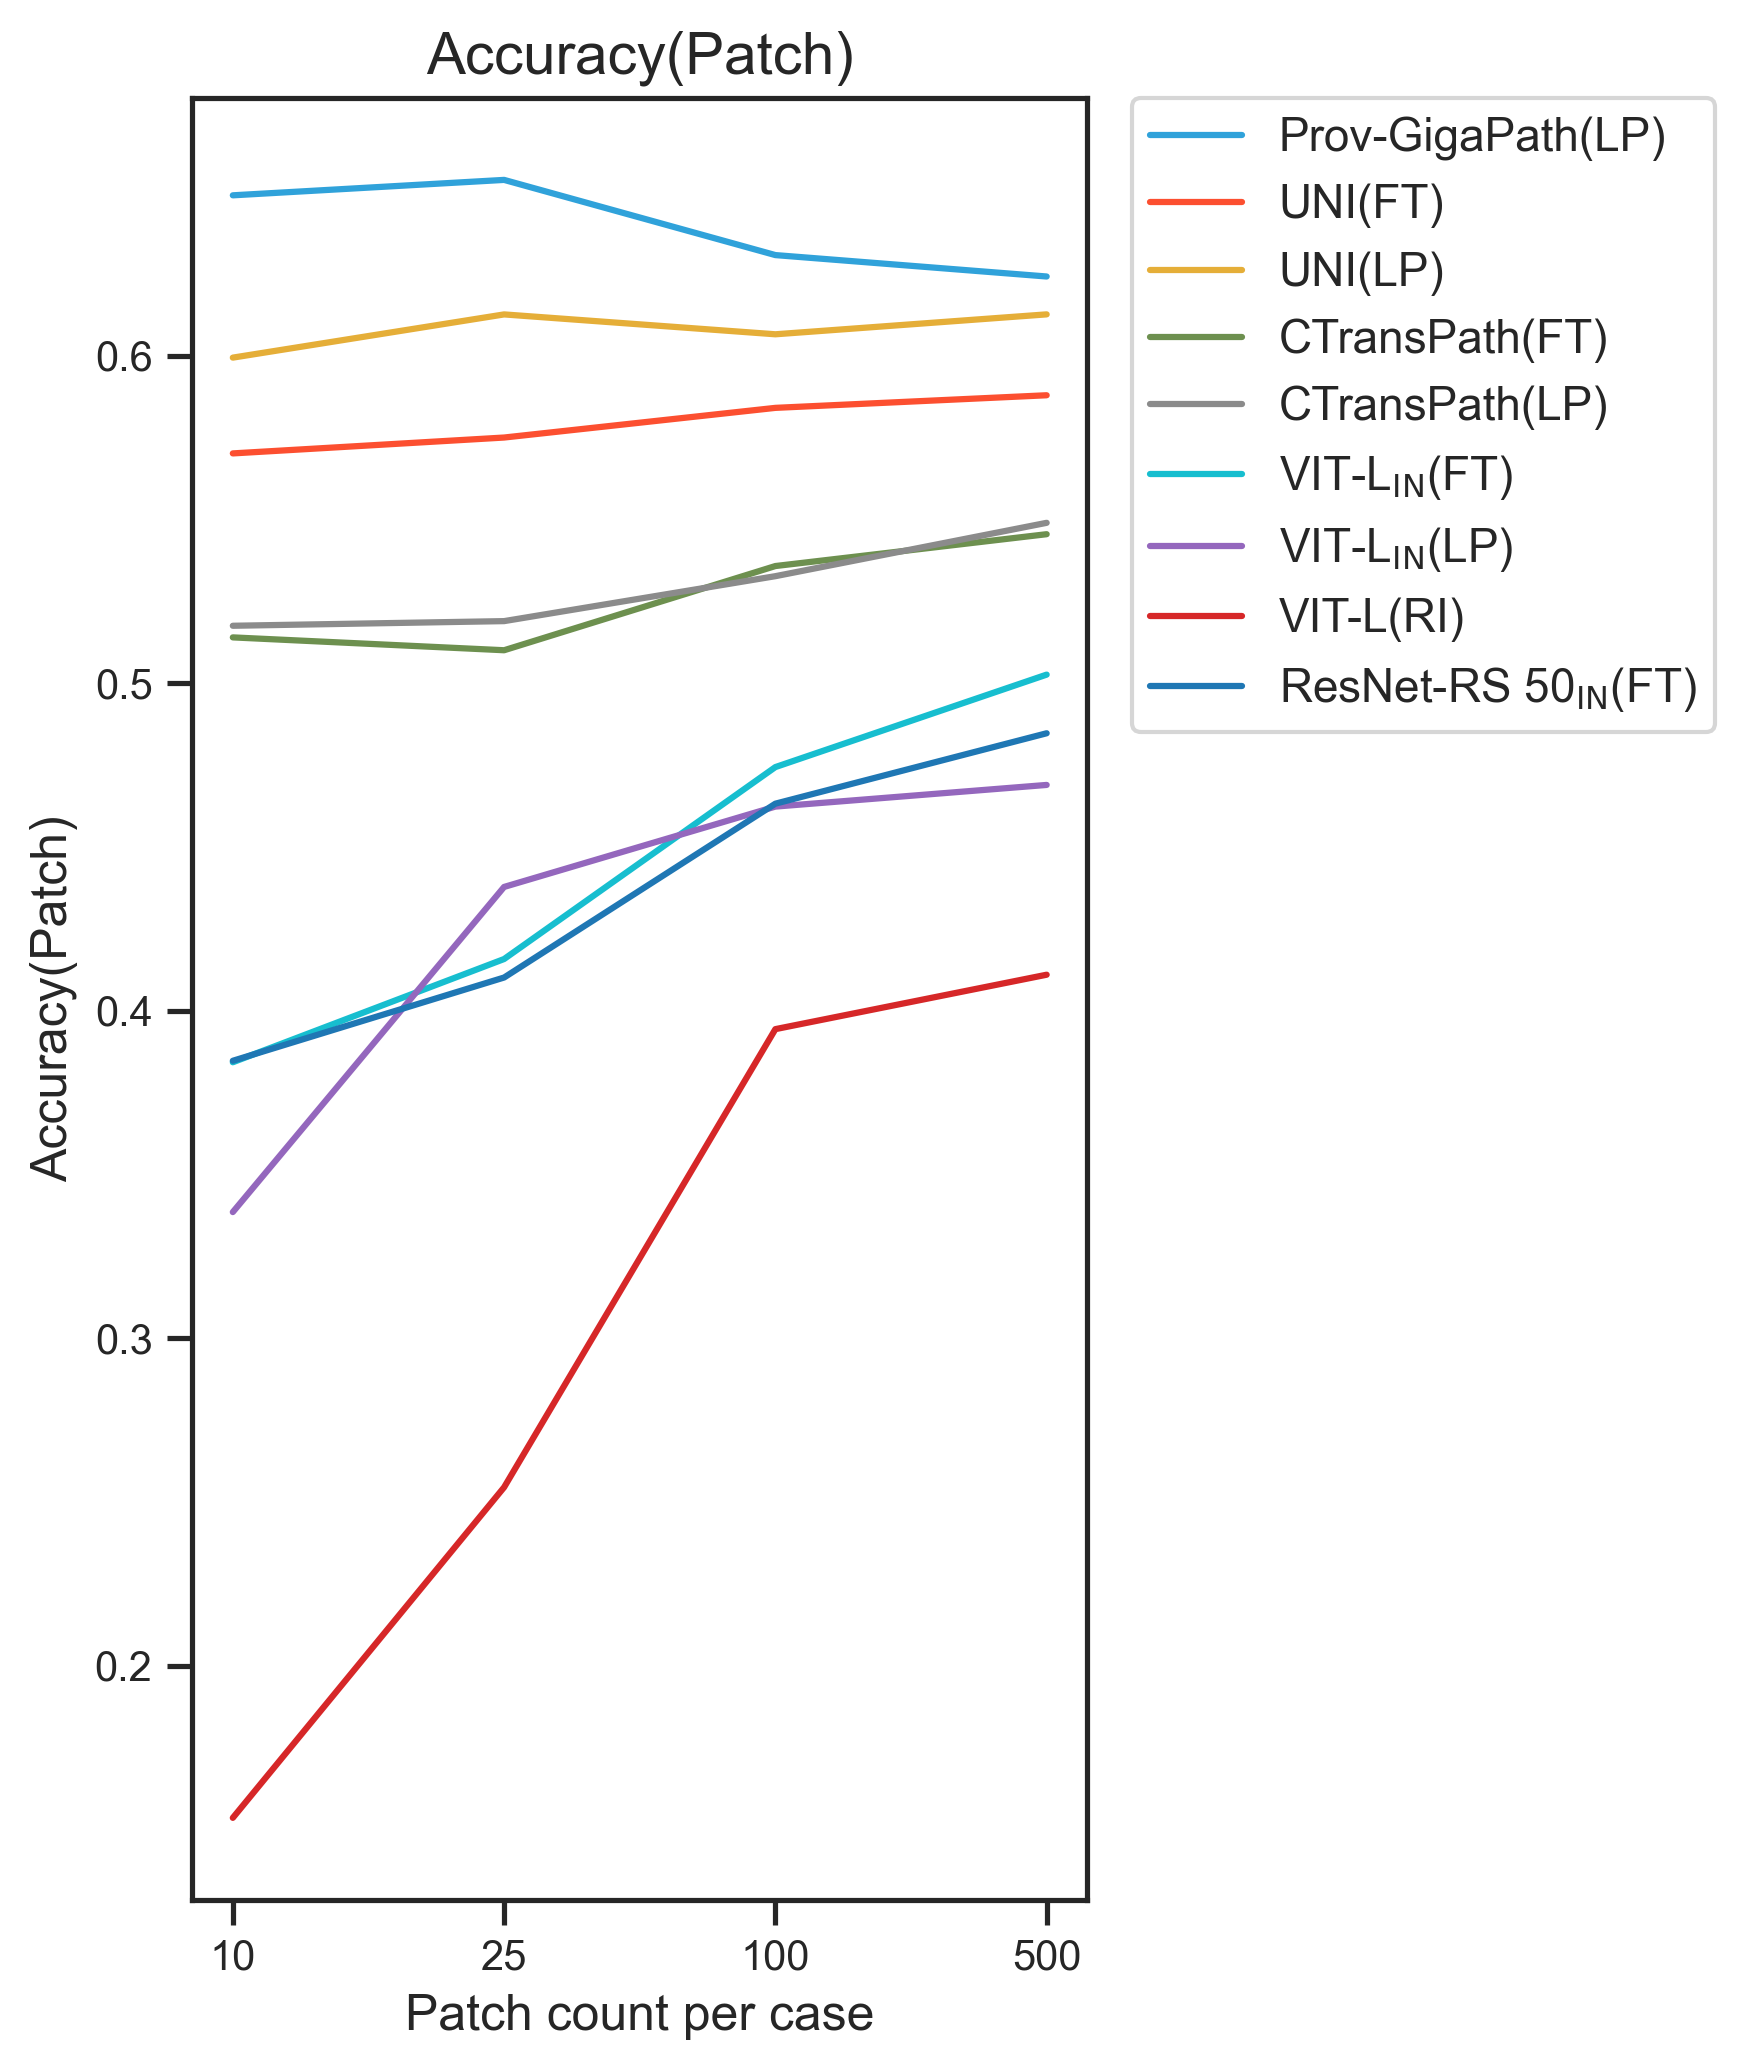

wrote out/figs/lines_ebrains_fine_recall.png


wrote out/figs/lines_ebrains_fine_acc.png
wrote out/figs/lines_ebrains_fine_f1.png


In [12]:
draw_lines('cv', 'pacc', False, show=True)
draw_lines('cv', 'recall', False, show=True)
draw_lines('cv', 'acc', False)
draw_lines('cv', 'f1', False)

draw_lines('ebrains', 'pacc', False, show=True)
draw_lines('ebrains', 'recall', False, show=True)
draw_lines('ebrains', 'acc', False)
draw_lines('ebrains', 'f1', False)

### Fig4: EBRAINS - lines

wrote out/figs/lines_cv_coarse_pacc.png


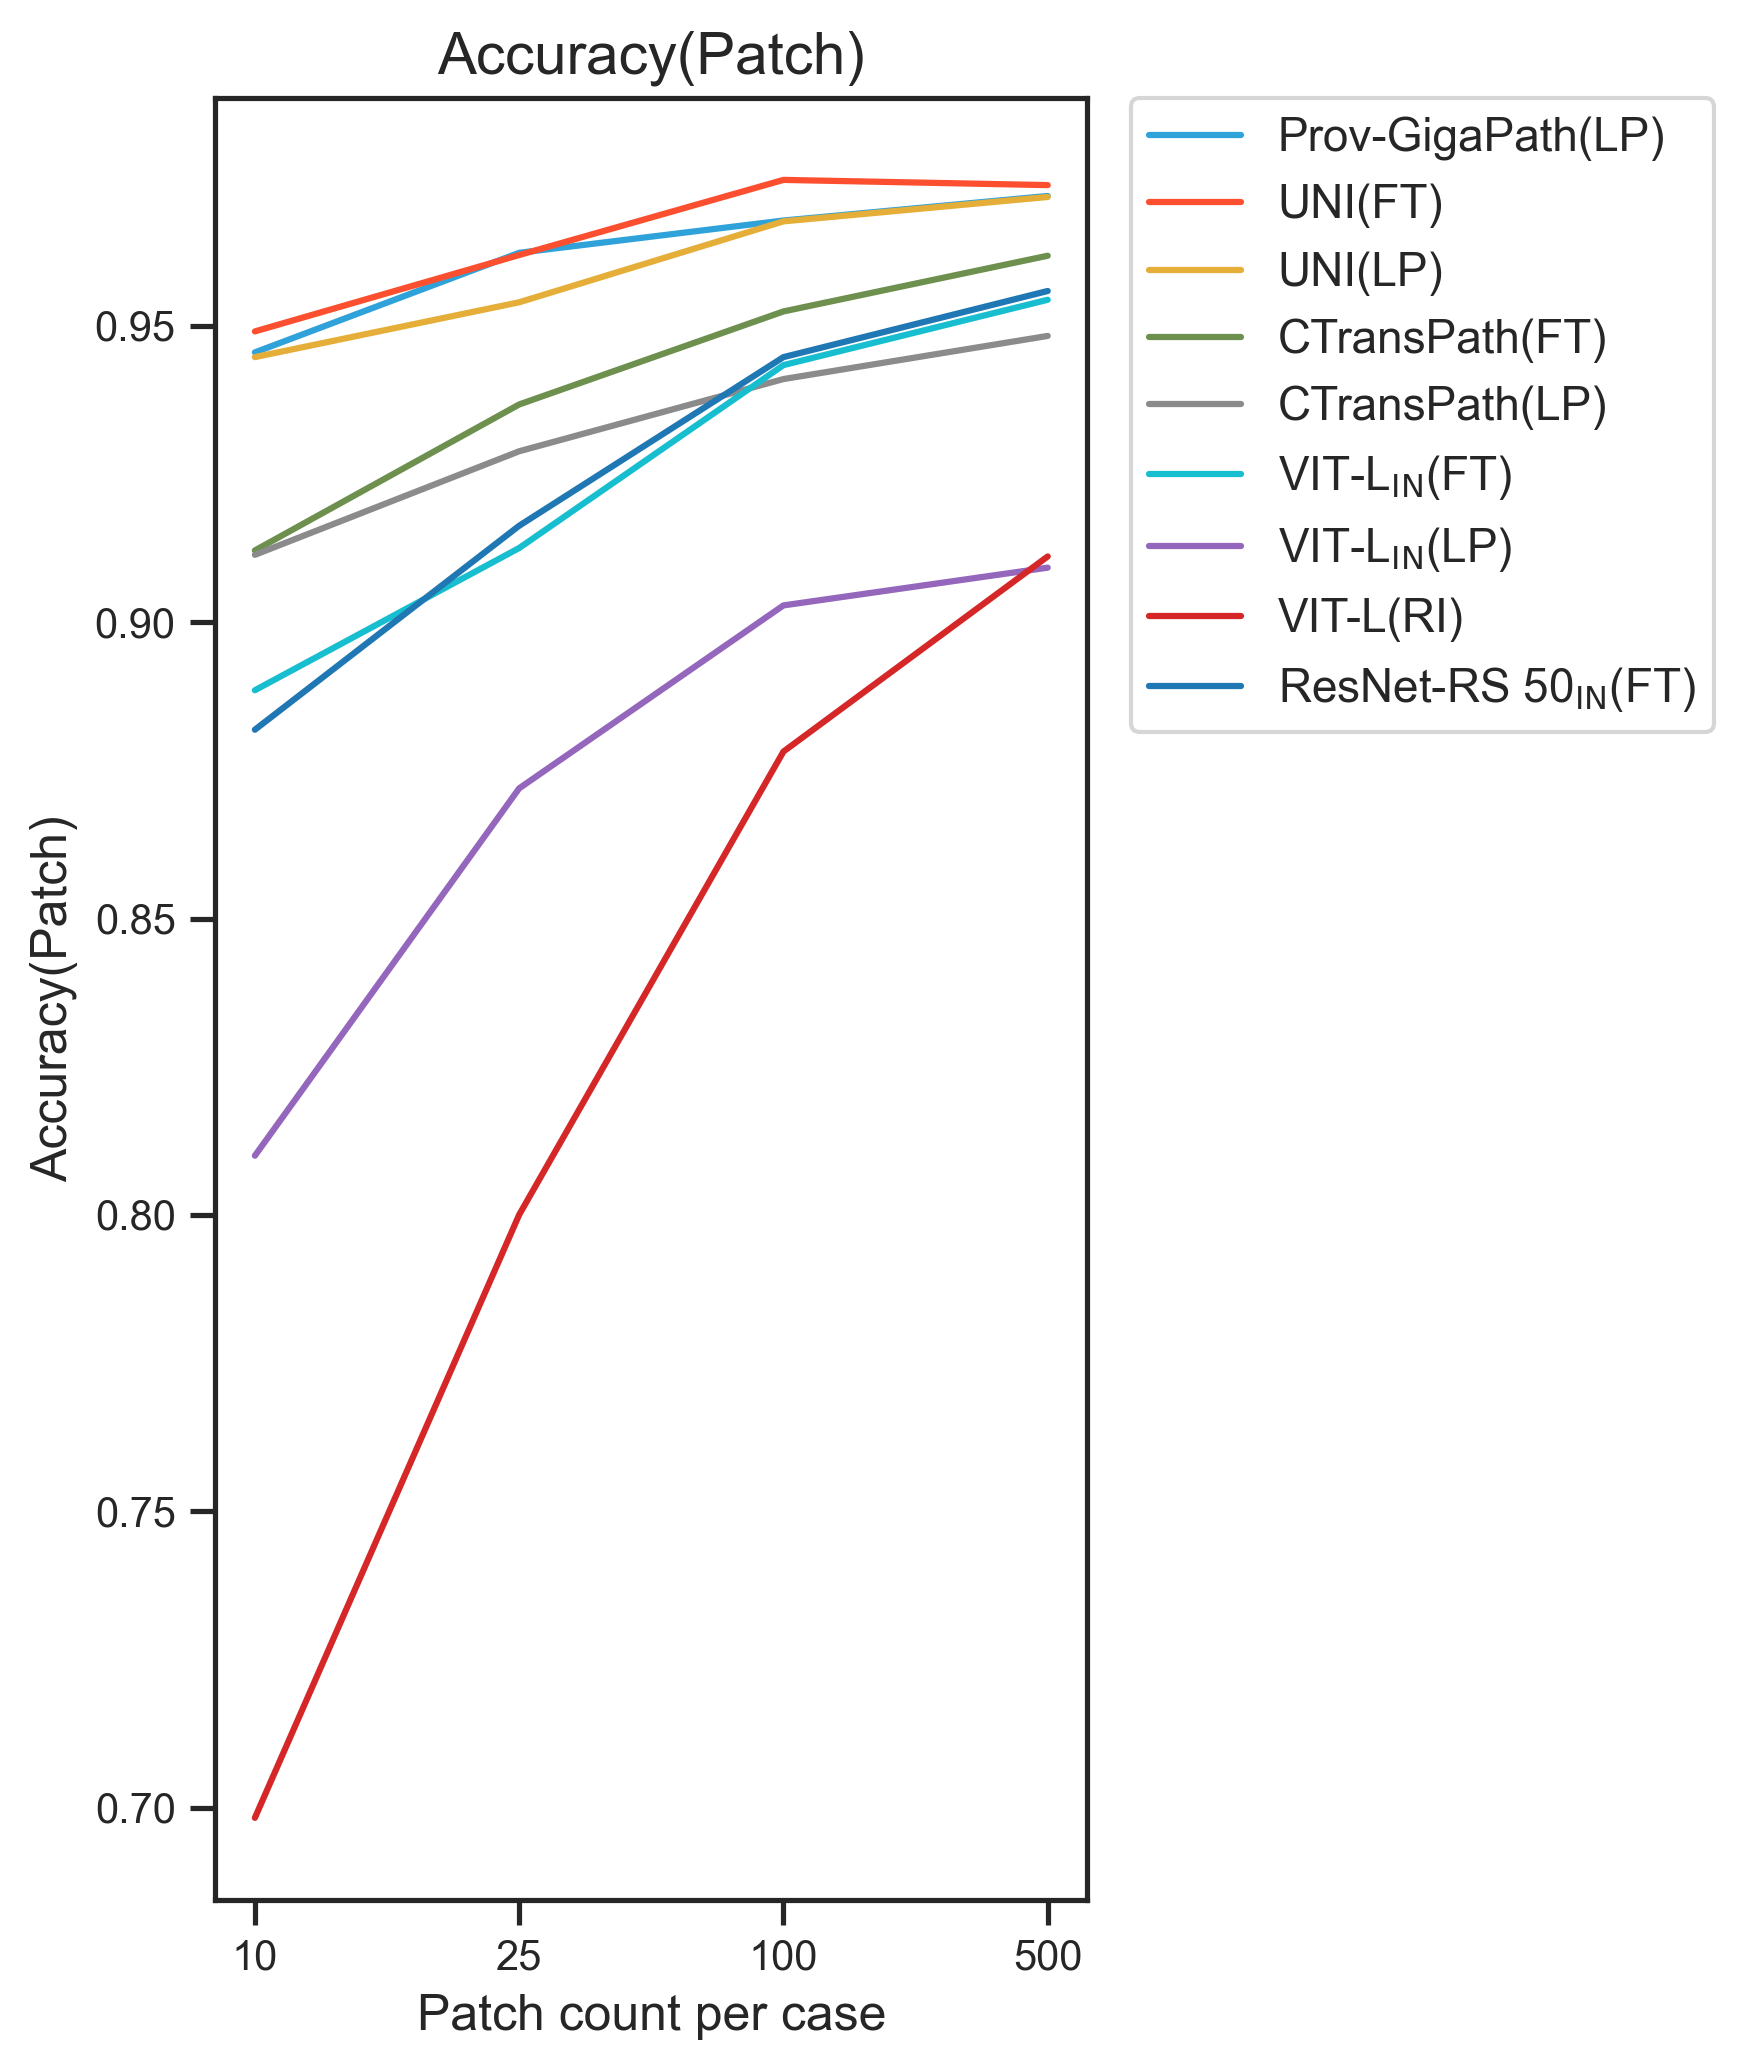

wrote out/figs/lines_cv_coarse_recall.png


wrote out/figs/lines_cv_coarse_acc.png
wrote out/figs/lines_cv_coarse_f1.png
wrote out/figs/lines_ebrains_coarse_pacc.png


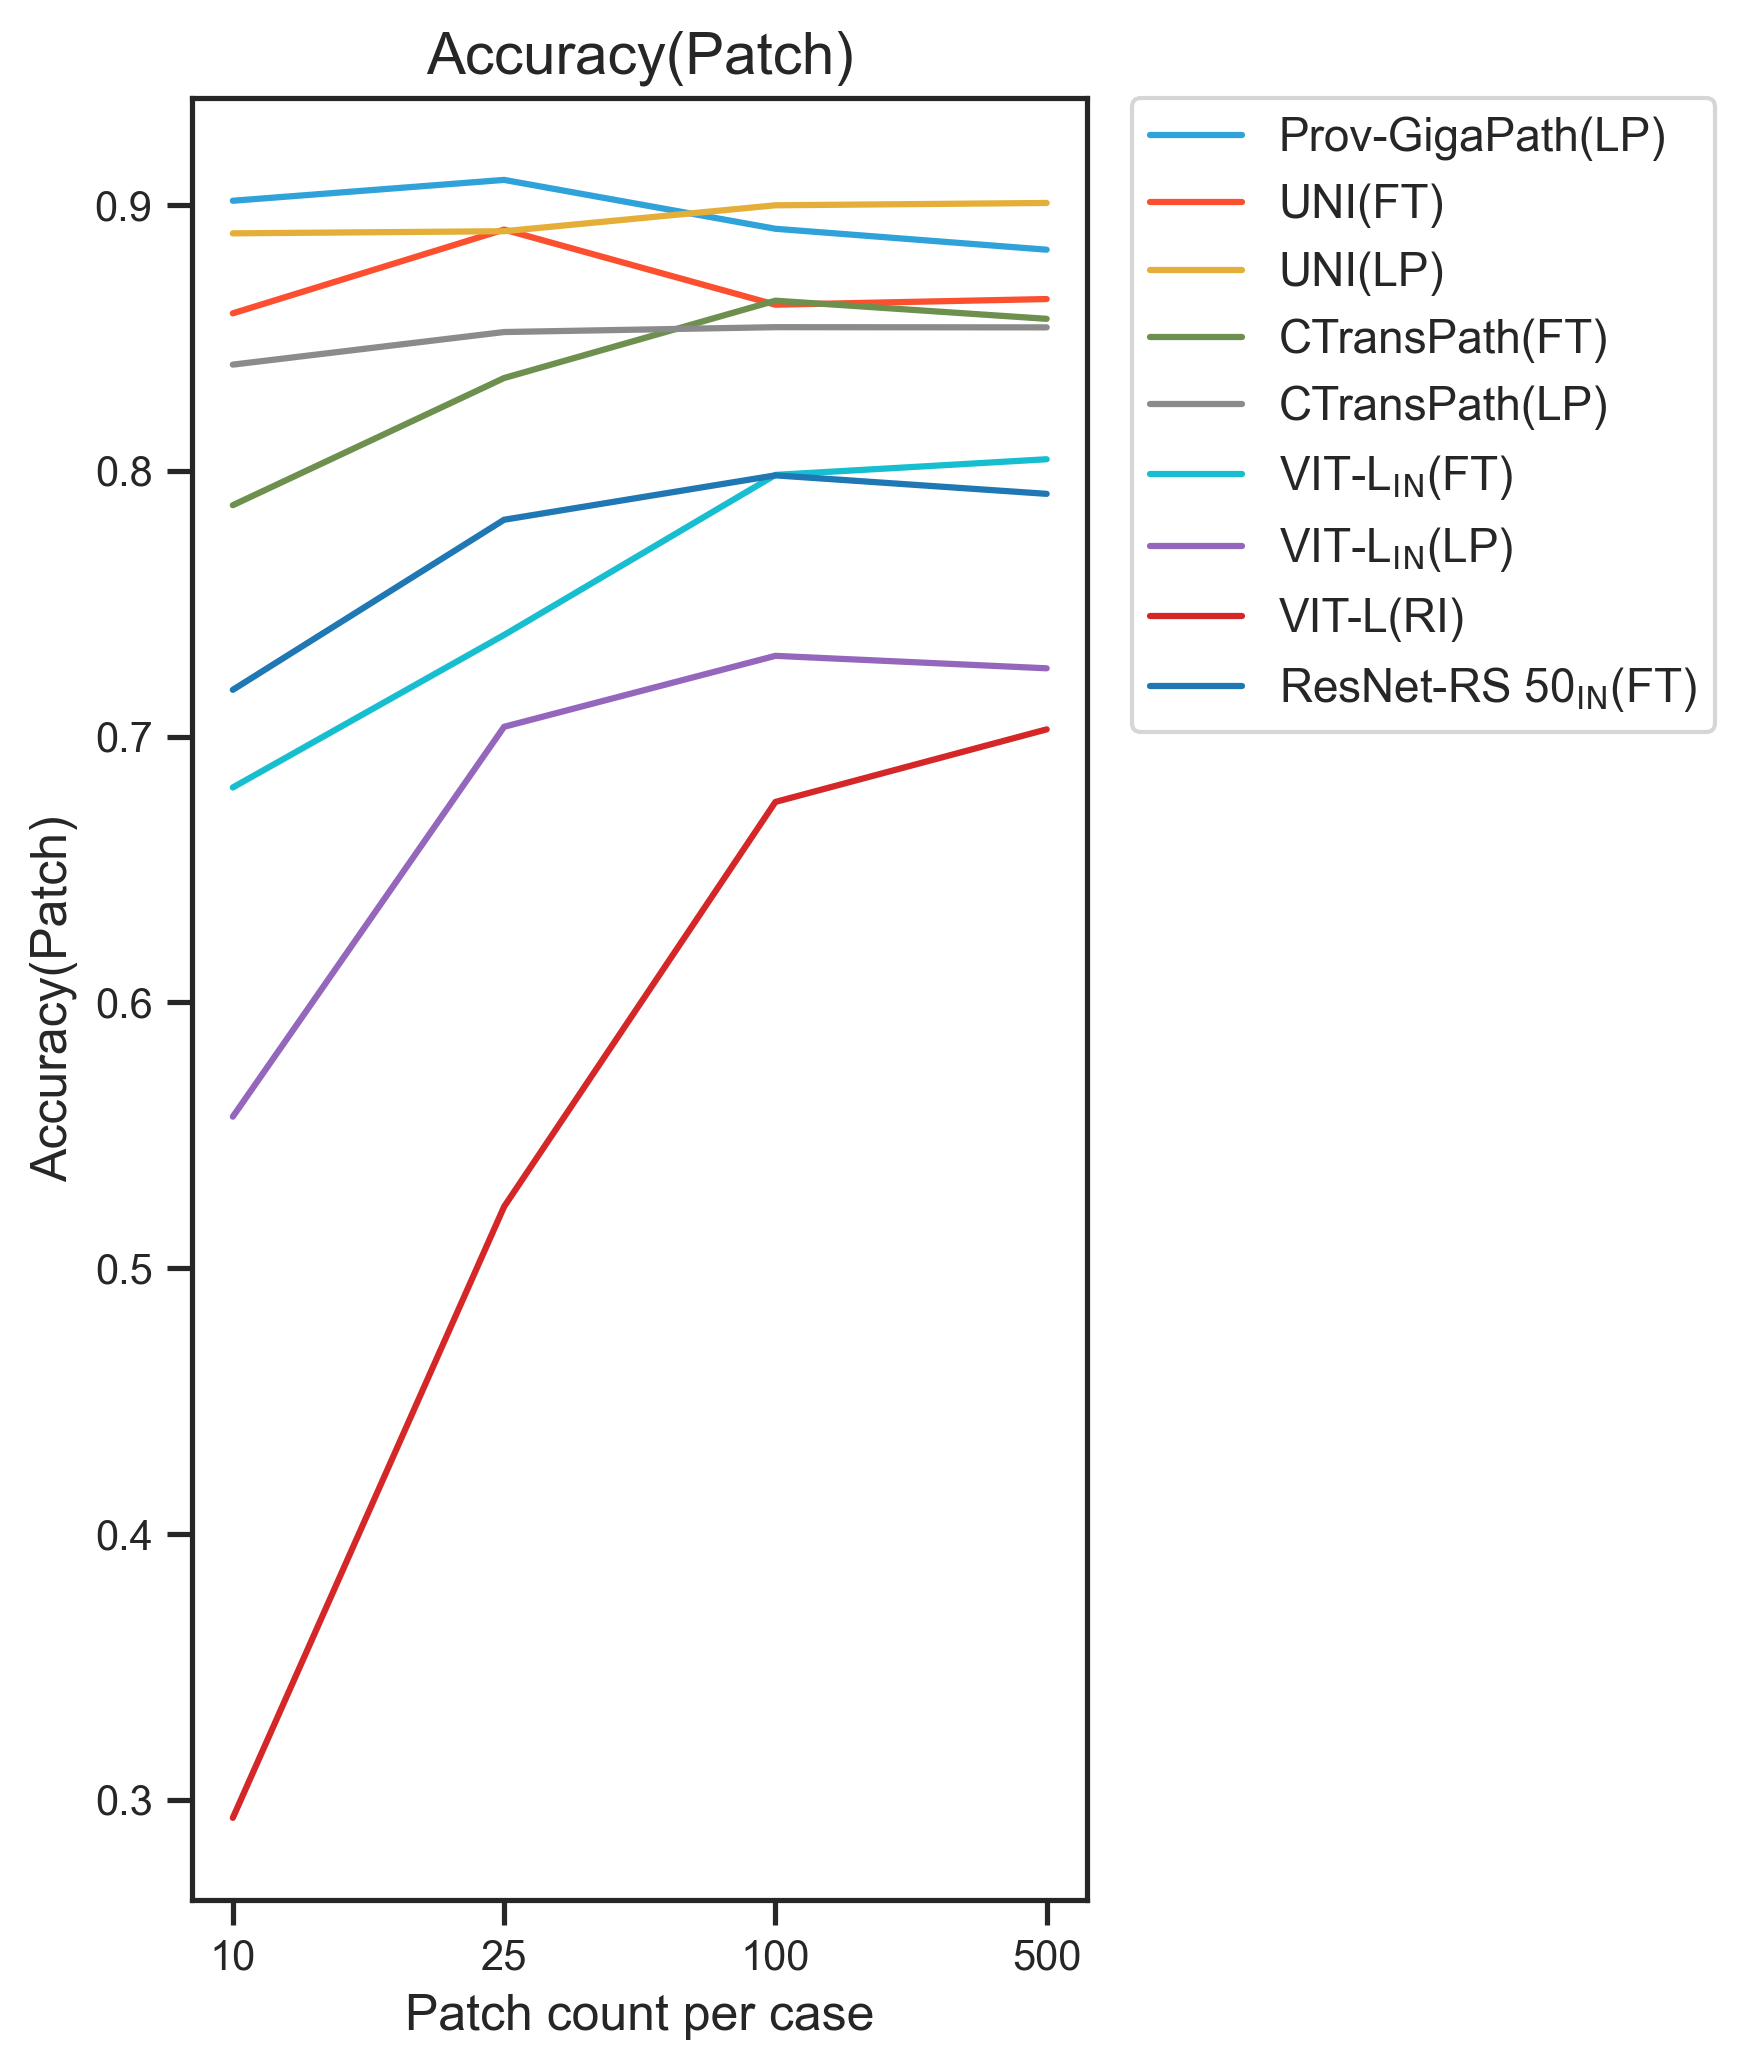

wrote out/figs/lines_ebrains_coarse_acc.png
wrote out/figs/lines_ebrains_coarse_f1.png


In [13]:
draw_lines('cv', 'pacc', True, show=True)
draw_lines('cv', 'recall', True, show=True)
draw_lines('cv', 'acc', True)
draw_lines('cv', 'f1', True)

draw_lines('ebrains', 'pacc', True, show=True)
draw_lines('ebrains', 'acc', True)
draw_lines('ebrains', 'f1', True)